# Department of Computer Science

## COS700 Research Project

### Explainable AI for Truthful Assessment in Low-Resource Languages

**Author**: Arno Jooste (u21457451)  
**Supervisors**: Prof. Vukosi Marivate, Ms. Seani Rananga, Mr. Thapelo Sindane  
**Date**: October 2024  

---

### Introduction

Misinformation has the potential to spread rapidly in low-resource languages like Afrikaans, where reliable information sources are limited. This notebook investigates the use of Explainable Artificial Intelligence (XAI) in the detection and analysis of misinformation translated from English into Afrikaans. By focusing on misinformation classification in a low-resource language, the study aims to explore how models can be made more interpretable for better understanding and trustworthiness.

The workflow involves four main steps:

1. **Translation:** Misinformation texts are first translated from English to Afrikaans, and the translation quality is assessed.
2. **Text Encoding:** BERT embeddings are generated from the translated texts, capturing their contextual information.
3. **Classification:** These embeddings are fed into different machine learning models — Random Forest, Logistic Regression, and SVM — to classify the misinformation.
4. **XAI Application:** The best-performing classification model is further analysed using LIME (Local Interpretable Model-agnostic Explanations) to explain its predictions.


In [1]:
# Installs
! pip install pandas
! pip install sacremoses

! pip install -U nltk
# ! pip install nltk==3.2.4
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
! pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inf

In [ ]:
# Install other requirements
! pip install ../requirements.txt

In [2]:
# Imports
from nltk import word_tokenize
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
import re
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from collections import Counter
import nltk
nltk.download('punkt_tab')
from transformers import BertModel, BertTokenizerFast
import torch.nn.functional as F
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from lime.lime_text import LimeTextExplainer
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Set seed
seed = 42

In [4]:
# Function to translate text from one language to another
def translate_texts(texts, src_lang, tgt_lang, model_name):
    if 'mbart' in model_name.lower():
        # mBART-50-MM settings
        tokenizer.src_lang = src_lang
        encoded_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        generated_tokens = model.generate(
            **encoded_texts,
            forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
            max_length=512,
            num_beams=4,
            early_stopping=True
        )
    elif 'helsinki' in model_name.lower():
        # Helsinki settings
        encoded_texts = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        generated_tokens = model.generate(
            **encoded_texts,
            max_length=512,
            num_beams=4,
            early_stopping=True
        )
    else:
        raise ValueError("Unsupported model name. Please use 'mbart' or 'helsinki' in the model name.")
    
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

def translate_texts_in_batches(text_from_source, text_from_target=None, src_lang='en_XX', tgt_lang='af_ZA', batch_size=8, model_name='helsinki'):
    translated_texts = []
    reference_texts = []

    # Translate texts in batches
    for i in range(0, len(text_from_source), batch_size):
        batch_source_texts = text_from_source[i:i+batch_size]
        if text_from_target is not None:
            batch_target_texts = text_from_target[i:i+batch_size]

        # Translate the batch of source texts
        translated_batch = translate_texts([text.strip() for text in batch_source_texts], src_lang, tgt_lang, model_name)  # English-to-Afrikaans

        # Store the translated and reference texts
        translated_texts.extend([text.split() for text in translated_batch])
        if text_from_target is not None:
            reference_texts.extend([[text.strip().split()] for text in batch_target_texts])

        # Clear GPU cache
        torch.cuda.empty_cache()

    if text_from_target is not None:
        return translated_texts, reference_texts
    else:
        return translated_texts

## Misinformation Dataset
### Acknowledgements

**[LIAR: A BENCHMARK DATASET FOR FAKE NEWS DETECTION](https://paperswithcode.com/dataset/liar)**

Download from [here](https://github.com/tfs4/liar_dataset).

**Description:** LIAR is a publicly accessible dataset designed for fake news detection. It comprises 12,800 manually labeled short statements collected over ten years from POLITIFACT.COM, which provides detailed analysis reports and links to source documents for each case. This dataset is also valuable for fact-checking research. Significantly, it is much larger than previously available public fake news datasets of a similar type. The LIAR dataset includes 12,800 human-labeled short statements from POLITIFACT.COM's API, with each statement evaluated for its truthfulness by a POLITIFACT.COM editor.

**Citation:**
William Yang Wang, "Liar, Liar Pants on Fire": A New Benchmark Dataset for Fake News Detection, to appear in Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (ACL 2017), short paper, Vancouver, BC, Canada, July 30-August 4, ACL.

In [6]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create smaller sample for source and target
src_lang = "en_XX"
tgt_lang = "af_ZA"
model_name = 'helsinki'
batch_size=8

# Load data from a TSV file
def load_tsv_data(file_path):
    return pd.read_csv(file_path, sep='\t', header=None)

# Remove unwanted columns
def drop_unwanted_columns(dataframe):
#     dataframe = dataframe.drop(dataframe.iloc[:, 3:], axis=1) # we only want the statement along with the label, this will be translated to Afrikaans
    column_names = ['ID', 'Label', 'Statement', 'Subject(s)',
                    'Speaker', 'Job Title', 'State Info',
                    'Party Affiliation', 'Barely True Counts',
                    'False Counts', 'Half True Counts', 'Mostly True Counts',
                    'Pants on fire Counts', 'Context'
                   ]
    dataframe = pd.DataFrame(dataframe)
    dataframe.columns = column_names
    return dataframe

# Load the training, validation, and test data
train_df = load_tsv_data('/kaggle/input/liar-dataset/train.tsv')
val_df = load_tsv_data('/kaggle/input/liar-dataset/valid.tsv')
test_df = load_tsv_data('/kaggle/input/liar-dataset/test.tsv')

# Remove unwanted data
train_df = drop_unwanted_columns(train_df)
val_df = drop_unwanted_columns(val_df)
test_df = drop_unwanted_columns(test_df)

# Extract text data
train_texts = train_df['Statement'].tolist()
val_texts = val_df['Statement'].tolist()
test_texts = test_df['Statement'].tolist()

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/819k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/297M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [7]:
train_df['Label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [8]:
counter = 0
bad_train_sentences = []
bad_val_sentences = []
bad_test_sentences = []

def append_bad_sentences(bad_sentences, texts, counter):
    for sentence in texts:
        if '.json' in sentence:
            counter += 1
            bad_sentences.append(sentence)
            print(len(sentence.split()))
            
    return bad_sentences

# handle train sentences
bad_train_sentences = append_bad_sentences(bad_train_sentences, train_texts, counter)
print(counter)
bad_train_df = pd.DataFrame(bad_train_sentences, columns=['Bad Sentences'])
print(bad_train_df)
print()

# handle val sentences
counter = 0
bad_val_sentences = append_bad_sentences(bad_val_sentences, val_texts, counter)
print(counter)
bad_val_df = pd.DataFrame(bad_val_sentences, columns=['Bad Sentences'])
print(bad_val_df)
print()

# handle test sentences
counter = 0
bad_test_sentences = append_bad_sentences(bad_test_sentences, test_texts, counter)
print(counter)
bad_test_df = pd.DataFrame(bad_test_sentences, columns=['Bad Sentences'])
print(bad_test_df)

467
88
235
43
309
0
                                       Bad Sentences
0  Hospitals, doctors, MRIs, surgeries and so for...
1  The fact is that although we have had a presid...
2  Georgia has the most restrictive ballot access...
3  When you were casting your vote for Republican...
4  The vast majority of the money I got was from ...

0
Empty DataFrame
Columns: [Bad Sentences]
Index: []

431
205
0
                                       Bad Sentences
0  As a state rep, I was considered the fourth-mo...
1  Fifty-six percent decline in overall crime. A ...


Since there are only a few records being faulty we can remove them.

In [9]:
# Remove records containing the bad sentence in the "Statement" column
train_df = train_df[~train_df['Statement'].isin(bad_train_sentences)]
train_texts = train_df['Statement'].tolist()
print(len(train_texts))

val_df = val_df[~val_df['Statement'].isin(bad_val_sentences)]
val_texts = val_df['Statement'].tolist()
print(len(val_texts))

test_df = test_df[~test_df['Statement'].isin(bad_test_sentences)]
test_texts = test_df['Statement'].tolist()
print(len(test_texts))

10235
1284
1265


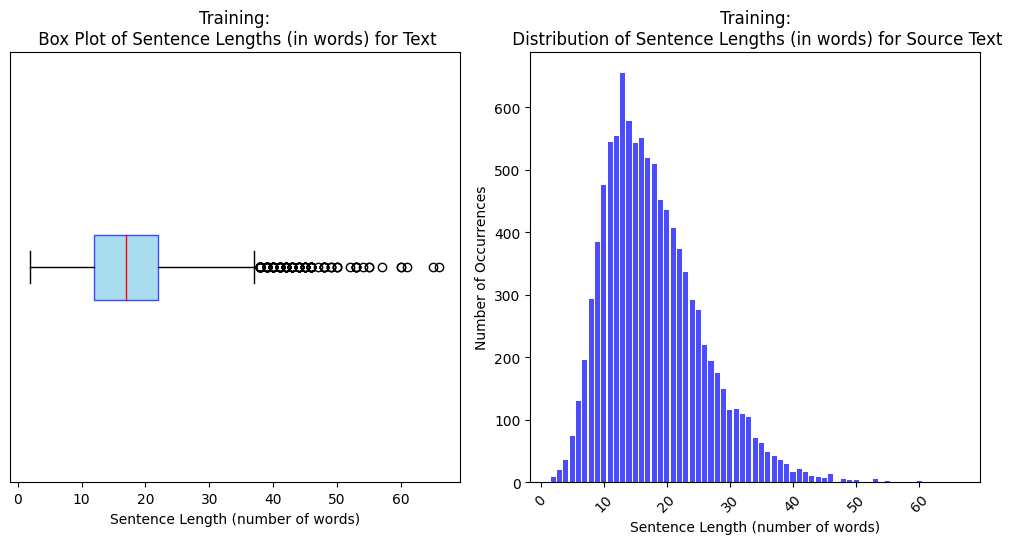

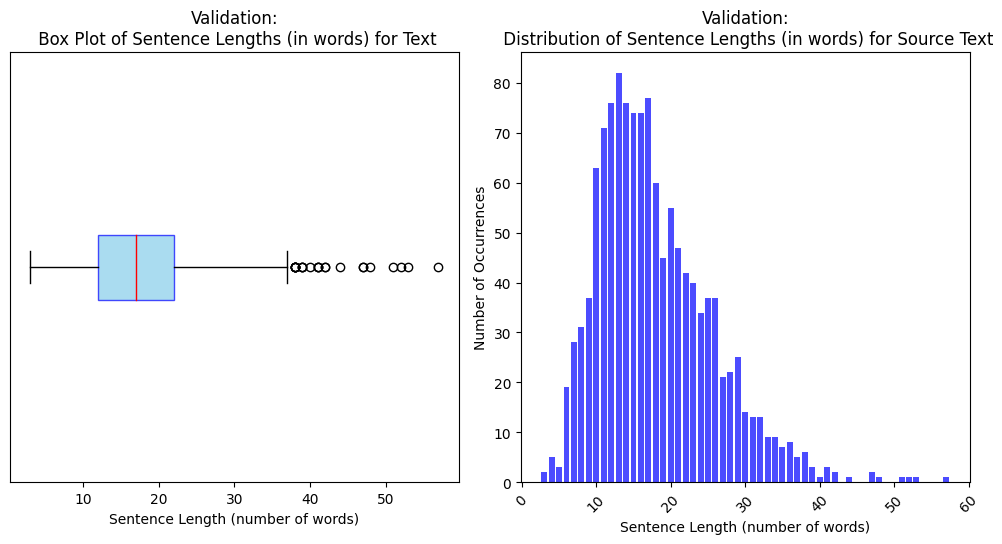

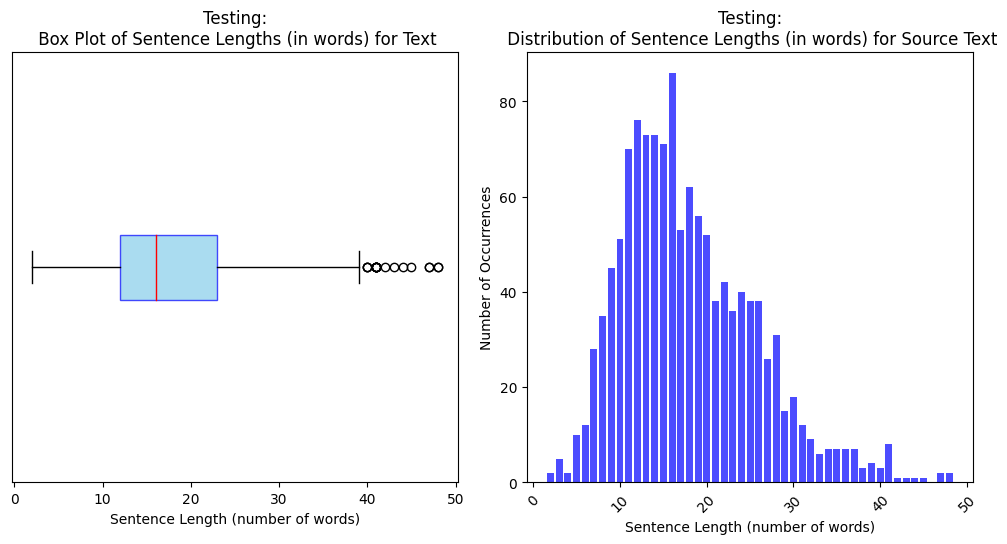

In [10]:
def visualise_sentence_lengths_distribution(texts, split='Training'):
    # Extract sentence lengths (in words) into list
    sentence_lengths = [len(sentence.split()) for sentence in texts]

    # Calculate frequency distributions
    sentence_length_counts = Counter(sentence_lengths)

    # Sort the lengths for consistent plotting
    sorted_sentence_lengths = sorted(sentence_length_counts.keys())
    sorted_length_counts = [sentence_length_counts[length] for length in sorted_sentence_lengths]

    plt.figure(figsize=(10,10))

    # 1st plot - Box plot for sentence lengths
    plt.subplot(2, 2, 1)
    plt.boxplot(sentence_lengths, vert=False, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='blue', alpha=0.7),
                medianprops=dict(color='red'))
    plt.title(f'{split}:\n Box Plot of Sentence Lengths (in words) for Text')
    plt.xlabel('Sentence Length (number of words)')
    plt.yticks([])

    # 2nd plot - Bar plot for source sentence lengths
    plt.subplot(2, 2, 2)
    plt.bar(sorted_sentence_lengths, sorted_length_counts, color='blue', alpha=0.7)
    plt.title(f'{split}:\n Distribution of Sentence Lengths (in words) for Source Text')
    plt.xlabel('Sentence Length (number of words)')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show plot
    plt.show()
    
    return sentence_lengths
    
train_sentence_lengths = visualise_sentence_lengths_distribution(train_texts)
val_sentence_lengths = visualise_sentence_lengths_distribution(val_texts, 'Validation')
test_sentence_lengths = visualise_sentence_lengths_distribution(test_texts, 'Testing')

In [11]:
print('Training:')
print(max(train_sentence_lengths))
print(min(train_sentence_lengths))

print('\nValidation:')
print(max(val_sentence_lengths))
print(min(val_sentence_lengths))

print('\nTesting:')
print(max(test_sentence_lengths))
print(min(test_sentence_lengths))

Training:
66
2

Validation:
57
3

Testing:
48
2


### Handle Outliers

Training set:
10.0
Upper Bound: 37.0
230
Lower Bound: -3.0
0


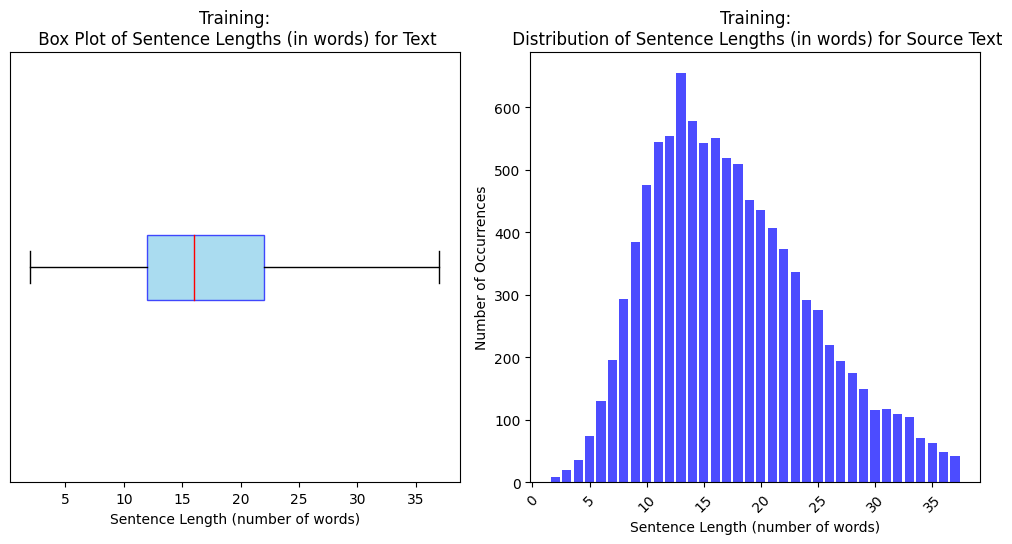

Validation set:
10.0
Upper Bound: 37.0
28
Lower Bound: -3.0
0


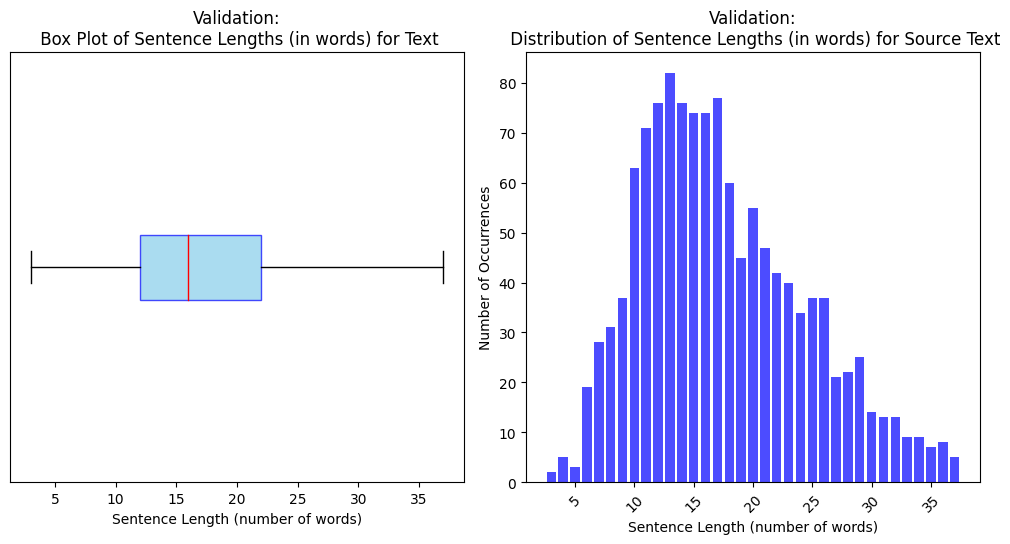

Testing set:
11.0
Upper Bound: 39.5
19
Lower Bound: -4.5
0


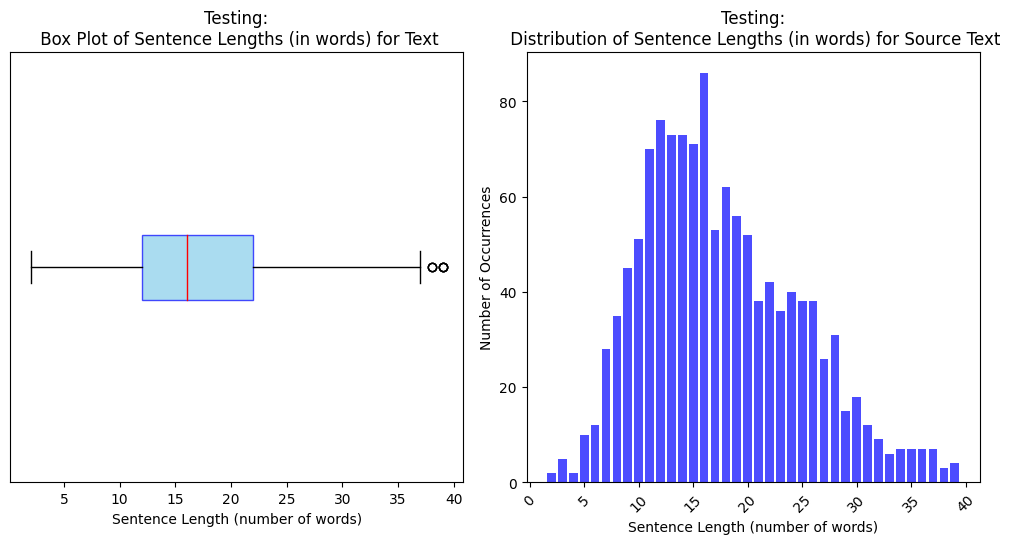

In [12]:
def handle_outliers(texts, sentence_lengths, split='Training'):
    # IQR
    Q1 = np.percentile(sentence_lengths, 25, method='midpoint')
    Q3 = np.percentile(sentence_lengths, 75, method='midpoint')
    IQR = Q3 - Q1
    print(f'{split} set:')
    print(IQR)

    # Above Upper bound
    upper_bound = Q3+1.5*IQR
    upper_array = np.array(sentence_lengths >= upper_bound)
    print("Upper Bound:", upper_bound)
    print(upper_array.sum())

    # Below Lower bound
    lower_bound = Q1-1.5*IQR
    lower_array = np.array(sentence_lengths <= lower_bound)
    print("Lower Bound:", lower_bound)
    print(lower_array.sum())

    # Remove outliers
    filtered_texts = []

    for sentence, length in zip(texts, sentence_lengths):
        if lower_bound <= length <= upper_bound:
            filtered_texts.append(sentence)
            
    visualise_sentence_lengths_distribution(filtered_texts, split)
    
# Training set outliers
handle_outliers(train_texts, train_sentence_lengths)

# Validation set outliers
handle_outliers(val_texts, val_sentence_lengths, 'Validation')

# Testing set outliers
handle_outliers(test_texts, test_sentence_lengths, 'Testing')

In [13]:
# Create dataframe from train_texts and make the column header "Sentence"
train_texts_df = pd.DataFrame(train_texts, columns=['Sentence'])
train_texts_df

Sentence
0      Says the Annies List political group supports ...
1      When did the decline of coal start? It started...
2      Hillary Clinton agrees with John McCain "by vo...
3      Health care reform legislation is likely to ma...
4      The economic turnaround started at the end of ...
...                                                  ...
10230  There are a larger number of shark attacks in ...
10231  Democrats have now become the party of the [At...
10232  Says an alternative to Social Security that op...
10233  On lifting the U.S. Cuban embargo and allowing...
10234  The Department of Veterans Affairs has a manua...

[10235 rows x 1 columns]

In [14]:
# Create dataframe from val_texts and make the column header "Sentence"
val_texts_df = pd.DataFrame(val_texts, columns=['Sentence'])
val_texts_df

Sentence
0     We have less Americans working now than in the...
1     When Obama was sworn into office, he DID NOT u...
2     Says Having organizations parading as being so...
3        Says nearly half of Oregons children are poor.
4     On attacks by Republicans that various program...
...                                                 ...
1279  For the first time in more than a decade, impo...
1280  Says Donald Trump has bankrupted his companies...
1281  John McCain and George Bush have "absolutely n...
1282  A new poll shows 62 percent support the presid...
1283  No one claims the report vindicating New Jerse...

[1284 rows x 1 columns]

In [15]:
# Create dataframe from test_texts and make the column header "Sentence"
test_texts_df = pd.DataFrame(test_texts, columns=['Sentence'])
test_texts_df

Sentence
0     Building a wall on the U.S.-Mexico border will...
1     Wisconsin is on pace to double the number of l...
2     Says John McCain has done nothing to help the ...
3     Suzanne Bonamici supports a plan that will cut...
4     When asked by a reporter whether hes at the ce...
...                                                 ...
1260  Says his budget provides the highest state fun...
1261                    Ive been here almost every day.
1262  In the early 1980s, Sen. Edward Kennedy secret...
1263  Says an EPA permit languished under Strickland...
1264  Says the governor is going around the state ta...

[1265 rows x 1 columns]

### Use Gemini for translations

In [16]:
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from google.api_core.exceptions import ResourceExhausted, InternalServerError
import time
from datetime import timedelta

harmful = []

# Define the Gemini class
class Gemini:
    def __init__(self, model_name):
        self.all_translations = []
        self.fitness_scores = []
        self.invalidIndices = []
        self.translation_indexes = []
        # Configure the Google Gemini API key
        genai.configure(api_key="{os.environ['GEMINI_API_KEY']}")

        # Define the model
        self.model = genai.GenerativeModel(model_name) # 'gemini-1.5-flash' or "gemini-1.0-pro"

    def generate_Gemini_translations(self, df, output_file, indexes_output_file):
        source_sentences = df['Sentence']
        count = 0
        interval_count = 0

        while len(source_sentences) != 0:
            try:
                # The API seems to only handle 16 requests per minute (RPM)
                if interval_count >= 15:
                    wait_time = 61  # 1 minute and 1 second
                    print()
                    print('We\'ve hit the maximum RPM. Waiting for 1 minute...')

                    for remaining in range(wait_time, 0, -1):
                        print(f'\rWaiting... {timedelta(seconds=remaining)} remaining', end='')
                        time.sleep(1)
                    print('\nResuming...')
                    interval_count = 0
                else:
                    # Generate translation
                    response = self.model.generate_content(f"Translate the sentence to Afrikaans: {source_sentences.iloc[0]}",
                                    safety_settings={
                                        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                                        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
                                    })

                    # Extract the translated text
#                     translated_text = response.text
#                     self.all_translations.append(translated_text)
#                     count += 1
#                     interval_count += 1
#                     print('\rTranslations completed: ', count, end='')
#                     source_sentences = source_sentences[1:] # remove the first element which we just translated

                    # Error handling for faulty response.text
                    try:
                        # Extract the translated text
                        translated_text = response.text

                        # Check if response.text is valid
                        if translated_text:
                            self.all_translations.append(translated_text)
                            count += 1
                            interval_count += 1
                            self.translation_indexes.append(df.index[df['Sentence'] == source_sentences.iloc[0]][0])
                            print('\rTranslations completed: ', count, end='')
                            source_sentences = source_sentences[1:]  # remove the first element which we just translated
                        else:
                            print(f'Invalid response.text for the text: "{source_sentences[0]}"')
                            source_sentences = source_sentences[1:]  # skip this translation
                            continue  # Skip to the next iteration of the loop
                    except ValueError as e:
                        print(f"Error accessing response.text: {e}")
                        print(f"Response Feedback: {response.prompt_feedback}")
                        source_sentences = source_sentences[1:]  # Skip to the next iteration of the loop
            except ValueError: # Add check if model does not return a text property
                print()
                invalidIndex = list(source_sentences).index(source_sentences[0])
                self.invalidIndices.append(invalidIndex)
                print(f'response.text most likely caused an error for the text: "{source_sentences[0]}"')
                source_sentences = source_sentences[1:] # we skip this translation since it cannot be handled by Gemini
            except ResourceExhausted:
                wait_time = 61  # 1 minute and 1 second
                print()
                print('Resource exhausted. Waiting for 1 minute...')

                for remaining in range(wait_time, 0, -1):
                    print(f'\rWaiting... {timedelta(seconds=remaining)} remaining', end='')
                    time.sleep(1)
                print('\nResuming...')
            except InternalServerError:
                # Save translations to a text file
                with open(output_file, 'w') as f:
                    for translation in self.all_translations:
                        f.write("%s\n" % translation)
                        
                # Save indexes of translations
                with open(indexes_output_file, 'w') as f:
                    for index in self.translation_indexes:
                        f.write("%s\n" % index)
                
                print(f'InternalServerError encountered...translations completed and saved: {count}')
            # print(f"Generated Translation: {translated_text}")

        # Save translations to a text file
        with open(output_file, 'w') as f:
            for translation in self.all_translations:
                f.write("%s\n" % translation)
        
        # Save indexes of translations
        with open(indexes_output_file, 'w') as f:
            for index in self.translation_indexes:
                f.write("%s\n" % index)

        return self.all_translations

def run_GEMINI_program(df, model, output_file, indexes_output_file):
    return model.generate_Gemini_translations(df, output_file, indexes_output_file)

# Define Models
GEMINI_model = Gemini('gemini-1.0-pro')

In [17]:
# GEMINI_translations = run_GEMINI_program(val_texts_df[0:-1], model=GEMINI_model, output_file='../data/val-set-gemini-af-translations.txt', indexes_output_file='../data/output/val-set-indexes-af-translations.txt')
# GEMINI_translations

In [18]:
# # If run failed, run this to save output file
# with open('../data/val-set-gemini-af-translations.txt', 'w') as f:
#     for translation in GEMINI_model.all_translations:
#         f.write("%s\n" % translation)
        
# with open('../data/output/val-set-indexes-af-translations.txt', 'w') as f:
#     for index in GEMINI_model.translation_indexes:
#         f.write("%s\n" % index)

In [19]:
# len(GEMINI_model.all_translations)

## Calculating similarity score

#### Model: LaBSE
Source: [here](https://huggingface.co/Blaxzter/LaBSE-sentence-embeddings)

**Model description** (from source page)

Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

- Model: [HuggingFace's model hub](https://huggingface.co/setu4993/LaBSE).
- Paper: [arXiv](https://arxiv.org/abs/2007.01852).
- Original model: [TensorFlow Hub](https://tfhub.dev/google/LaBSE/2).
- Blog post: [Google AI Blog](https://ai.googleblog.com/2020/08/language-agnostic-bert-sentence.html).
- Conversion from TensorFlow to PyTorch: [GitHub](https://github.com/setu4993/convert-labse-tf-pt).

This is migrated from the v2 model on the TF Hub, which uses dict-based input. The embeddings produced by both the versions of the model are [equivalent](https://github.com/setu4993/convert-labse-tf-pt/blob/ec3a019159a54ed6493181a64486c2808c01f216/tests/test_conversion.py#L31).

In [81]:
# Training set
train_gemini_af_translations = []
train_translation_indexes = []
with open('../data/train-set-gemini-af-translations/train-set-gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        train_gemini_af_translations.append(sentence)
        
with open('../data/train-set-gemini-af-translations/train-set-indexes-af-translations.txt', 'r') as f:
    for index in f:
        train_translation_indexes.append(index)

# Validation set
val_gemini_af_translations = []
val_translation_indexes = []
with open('../data/val-set-gemini-af-translations/val-set-gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        val_gemini_af_translations.append(sentence)
        
with open('../data/val-set-gemini-af-translations/val-set-indexes-af-translations.txt', 'r') as f:
    for index in f:
        val_translation_indexes.append(index)

# Testing set
test_gemini_af_translations = []
test_translation_indexes = []
with open('../data/test-set-gemini-af-translations/test-set-gemini-af-translations.txt', 'r') as f:
    for sentence in f:
        test_gemini_af_translations.append(sentence)
        
with open('../data/test-set-gemini-af-translations/test-set-indexes-af-translations.txt', 'r') as f:
    for index in f:
        test_translation_indexes.append(index)

In [21]:
train_gemini_af_translations_df = pd.DataFrame(train_gemini_af_translations, columns=['Afrikaans Sentence'])
val_gemini_af_translations_df = pd.DataFrame(val_gemini_af_translations, columns=['Afrikaans Sentence'])
test_gemini_af_translations_df = pd.DataFrame(test_gemini_af_translations, columns=['Afrikaans Sentence'])
train_gemini_af_translations_df

Afrikaans Sentence
0     Die politieke groep Annies List sê dat hulle a...
1     Wanneer het die afname van steenkool begin? Di...
2     Hillary Clinton stem saam met John McCain "deu...
3     Gesondheidsorg-hervormingswetgewing sal waarsk...
4     Ekonomiese oplewing het aan die einde van my a...
...                                                 ...
9990  Die Republikeine het herhaaldelik gesê dat hul...
9991  'n Deeltydse Kongreslid met die helfte van die...
9992  Ongeveer 40 persent van sy kiesers in die McAl...
9993  Minnesota, Michigan en Iowa het reeds ŉ snelhe...
9994  Hy sê Barack Obama is met genot gefotografeer ...

[9995 rows x 1 columns]

In [22]:
train_translation_indexes_df = pd.DataFrame(train_translation_indexes, columns=['Index'])
val_translation_indexes_df = pd.DataFrame(val_translation_indexes, columns=['Index'])
test_translation_indexes_df = pd.DataFrame(test_translation_indexes, columns=['Index'])
train_translation_indexes_df

Index
0        0\n
1        1\n
2        2\n
3        3\n
4        4\n
...      ...
9990  9995\n
9991  9996\n
9992  9997\n
9993  9998\n
9994    9999

[9995 rows x 1 columns]

In [23]:
def replace_newline_chars(translations_df, indices_df):
    translations_df = translations_df.replace('\n', '', regex=True)
    indices_df = indices_df.replace('\n', '', regex=True)
    indices_df['Index'] = indices_df['Index'].astype(int)
    return translations_df, indices_df

train_gemini_af_translations_df, train_translation_indexes_df = replace_newline_chars(train_gemini_af_translations_df, train_translation_indexes_df)
val_gemini_af_translations_df, val_translation_indexes_df = replace_newline_chars(val_gemini_af_translations_df, val_translation_indexes_df)
test_gemini_af_translations_df, test_translation_indexes_df = replace_newline_chars(test_gemini_af_translations_df, test_translation_indexes_df)

In [24]:
def merge(indexes_df, translations_df):
    merged_df = pd.concat([indexes_df, translations_df], axis=1)
    return merged_df

train_merged_df = merge(train_translation_indexes_df, train_gemini_af_translations_df)
val_merged_df = merge(val_translation_indexes_df, val_gemini_af_translations_df)
test_merged_df = merge(test_translation_indexes_df, test_gemini_af_translations_df)
# val_merged_df
train_merged_df

Index                                 Afrikaans Sentence
0         0  Die politieke groep Annies List sê dat hulle a...
1         1  Wanneer het die afname van steenkool begin? Di...
2         2  Hillary Clinton stem saam met John McCain "deu...
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...
4         4  Ekonomiese oplewing het aan die einde van my a...
...     ...                                                ...
9990   9995  Die Republikeine het herhaaldelik gesê dat hul...
9991   9996  'n Deeltydse Kongreslid met die helfte van die...
9992   9997  Ongeveer 40 persent van sy kiesers in die McAl...
9993   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...
9994   9999  Hy sê Barack Obama is met genot gefotografeer ...

[9995 rows x 2 columns]

In [25]:
def add_original_sentences_and_labels(original_df, merged_df):
    # Find indices present in both merged_df['Index'] and original_df.index
    valid_indices = merged_df['Index'][merged_df['Index'].isin(original_df.index)]
    
    # Retrieve the original sentences using the valid indices
    matching_sentences = original_df.loc[valid_indices, 'Statement']
    
    # Retrieve the original labels using the valid indices
    matching_labels = original_df.loc[valid_indices, 'Label']
    
    # Reset the index of the matching sentences and labels to ensure alignment with merged_df
    matching_sentences = matching_sentences.reset_index(drop=True)
    matching_labels = matching_labels.reset_index(drop=True)
    
    # Filter merged_df to keep only the valid rows that matched
    merged_df = merged_df[merged_df['Index'].isin(original_df.index)].reset_index(drop=True)
    
    # Add the matching sentences and labels to the filtered merged_df
    merged_df['English Sentence'] = matching_sentences
    merged_df['English Labels'] = matching_labels
    
    # Return the merged DataFrame
    return merged_df

train_merged_df = add_original_sentences_and_labels(train_df, train_merged_df)
val_merged_df = add_original_sentences_and_labels(val_df, val_merged_df)
test_merged_df = add_original_sentences_and_labels(test_df, test_merged_df)

In [26]:
train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  
0     Says the Annies List political group supports ...          false  
1     When did the decline of coal start? It started...      half-true  
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true  
3     Health care reform legislation is likely to ma...          false  
4     The economic turnaround started at the end of ...      half-true  
...                                                 ...            ...  
9985  The Castro regime violated international norms...    mostly-true  
9986  Theres not one Democrat who endorses the Romne...           true  
9987  The United States death rate is two-and-a-half...           true  
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire  
9989    Donald Trump says hed deport 16 million people.      half-true  

[9990 rows x 4 columns]

The sentences seem to be matched even though some were skipped during the translation process due to those being faulty.

#### Add Afrikaans Labels

In [27]:
# Dictionary to help map English labels to Afrikaans labels
label_translation = {
    'false': 'vals',
    'half-true': 'half-waar',
    'mostly-true': 'meestal-waar',
    'true': 'waar',
    'barely-true': 'skaars-waar',
    'pants-fire': 'broek-vuur'
}


train_merged_df['Afrikaans Labels'] = train_merged_df['English Labels'].map(label_translation)
val_merged_df['Afrikaans Labels'] = val_merged_df['English Labels'].map(label_translation)
test_merged_df['Afrikaans Labels'] = test_merged_df['English Labels'].map(label_translation)

print(train_merged_df[['English Labels', 'Afrikaans Labels']])
print(val_merged_df[['English Labels', 'Afrikaans Labels']])
print(test_merged_df[['English Labels', 'Afrikaans Labels']])

     English Labels Afrikaans Labels
0             false             vals
1         half-true        half-waar
2       mostly-true     meestal-waar
3             false             vals
4         half-true        half-waar
...             ...              ...
9985    mostly-true     meestal-waar
9986           true             waar
9987           true             waar
9988     pants-fire       broek-vuur
9989      half-true        half-waar

[9990 rows x 2 columns]
     English Labels Afrikaans Labels
0       barely-true      skaars-waar
1        pants-fire       broek-vuur
2             false             vals
3         half-true        half-waar
4         half-true        half-waar
...             ...              ...
1277     pants-fire       broek-vuur
1278      half-true        half-waar
1279    mostly-true     meestal-waar
1280           true             waar
1281          false             vals

[1282 rows x 2 columns]
     English Labels Afrikaans Labels
0              true      

#### Now we continue to calculate the similarity scores

In [28]:
def prepare_english_afrikaans_sentences(merged_df):
    # Extract english sentences
    english_sentences = list(merged_df['English Sentence'][:100])

    # Extract afrikaans sentences
    afrikaans_sentences = list(merged_df['Afrikaans Sentence'][:100])

    # Remove newline characters from afrikaans_sentences
    afrikaans_sentences = [sentence.strip() for sentence in afrikaans_sentences]
    
    return english_sentences, afrikaans_sentences

def calculate_similarity_scores(english_sentences, afrikaans_sentences):
    # Initialise model and tokeniser
    tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
    model = BertModel.from_pretrained("setu4993/LaBSE")
    model = model.eval()

    # Get inputs
    english_inputs = tokenizer(english_sentences, return_tensors="pt", padding=True)
    afrikaans_inputs = tokenizer(afrikaans_sentences, return_tensors="pt", padding=True)

    # Get outputs
    with torch.no_grad():
        english_outputs = model(**english_inputs)
        afrikaans_outputs = model(**afrikaans_inputs)

    # Get embeddings
    english_embeddings = english_outputs.pooler_output
    afrikaans_embeddings = afrikaans_outputs.pooler_output
    
    return english_embeddings, afrikaans_embeddings

train_english_sentences, train_afrikaans_sentences = prepare_english_afrikaans_sentences(train_merged_df)
val_english_sentences, val_afrikaans_sentences = prepare_english_afrikaans_sentences(val_merged_df)
test_english_sentences, test_afrikaans_sentences = prepare_english_afrikaans_sentences(test_merged_df)

train_english_embeddings, train_afrikaans_embeddings = calculate_similarity_scores(train_english_sentences, train_afrikaans_sentences)
val_english_embeddings, val_afrikaans_embeddings = calculate_similarity_scores(val_english_sentences, val_afrikaans_sentences)
test_english_embeddings, test_afrikaans_embeddings = calculate_similarity_scores(test_english_sentences, test_afrikaans_sentences)

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [29]:
# Based on the source from HuggingFace, for similarity between sentences, an L2-norm is recommended before calculating the similarity
def similarity(embeddings_1, embeddings_2):
    normalized_embeddings_1 = F.normalize(embeddings_1, p=2)
    normalized_embeddings_2 = F.normalize(embeddings_2, p=2)
    return torch.matmul(
        normalized_embeddings_1, normalized_embeddings_2.transpose(0, 1)
    )

train_set_sim_scores = similarity(train_english_embeddings, train_afrikaans_embeddings)
val_set_sim_scores = similarity(val_english_embeddings, val_afrikaans_embeddings)
test_set_sim_scores = similarity(test_english_embeddings, test_afrikaans_embeddings)
print(train_set_sim_scores[0])
print(val_set_sim_scores[0])
print(test_set_sim_scores[0])

tensor([ 0.8554,  0.0719,  0.1580,  0.2458,  0.1536,  0.1214,  0.0938,  0.0855,
         0.0978,  0.1294,  0.1406,  0.0914,  0.0814,  0.0621,  0.1456,  0.1750,
         0.2608,  0.1281,  0.0235,  0.0777,  0.0969,  0.1221,  0.1056,  0.2953,
         0.3113,  0.0204,  0.1368,  0.1937,  0.2636,  0.1623,  0.1885,  0.0575,
         0.1689,  0.0567,  0.2262,  0.1572,  0.1577,  0.0347,  0.0881,  0.0300,
         0.1963,  0.1579,  0.1148,  0.3034,  0.1123,  0.0867,  0.1642,  0.0980,
         0.0227,  0.2197,  0.1912,  0.1437,  0.2262,  0.0943,  0.1049,  0.0836,
         0.0587, -0.0614,  0.2805,  0.1135,  0.1011,  0.1816,  0.1432,  0.0589,
         0.0520,  0.1521,  0.1561,  0.2021,  0.2842,  0.2730,  0.0182, -0.0258,
         0.2791,  0.0525,  0.0994,  0.0272,  0.1599,  0.1674,  0.3608,  0.0849,
         0.2366,  0.1362,  0.1531,  0.1791,  0.2464,  0.2004,  0.1272,  0.0725,
         0.2056,  0.1956,  0.2105,  0.0891,  0.1548,  0.2153,  0.0399,  0.2677,
         0.2004,  0.0635,  0.0881,  0.03

The `scores` variable returns a 2D array where each index `i` represents an English sentence, and the `j` would represent the Afrikaans sentences. Meaning `scores[0][0]` would represent the similarity score between the first English sentences and its corresponding Afrikaans translation. Therefore, we are not interested in the scores between non-corresponding translations.

In [30]:
# Extract the diagonal elements (similarity between each English sentence and its corresponding Afrikaans translation)
train_set_diagonal_scores = torch.diagonal(train_set_sim_scores)
val_set_diagonal_scores = torch.diagonal(val_set_sim_scores)
test_set_diagonal_scores = torch.diagonal(test_set_sim_scores)

# Convert to a 1D array
train_set_diagonal_scores_1d = train_set_diagonal_scores.tolist()
val_set_diagonal_scores_1d = val_set_diagonal_scores.tolist()
test_set_diagonal_scores_1d = test_set_diagonal_scores.tolist()

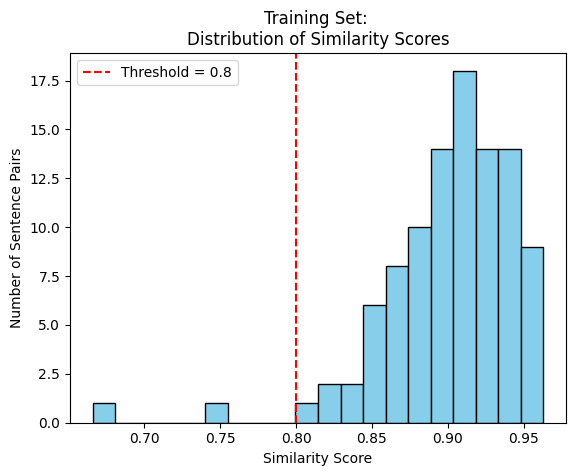

Max: 0.9629534482955933
Min: 0.6659683585166931


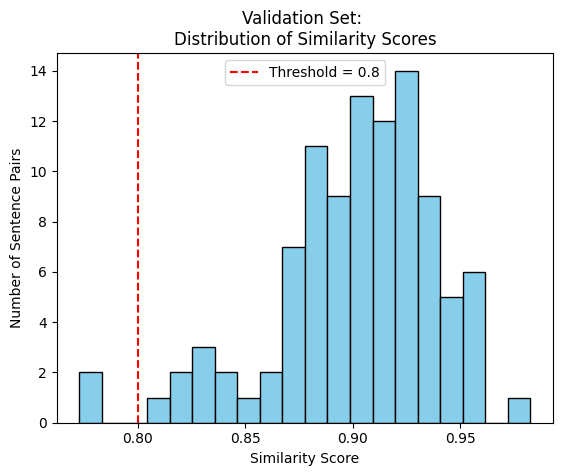

Max: 0.9824647903442383
Min: 0.7729893326759338


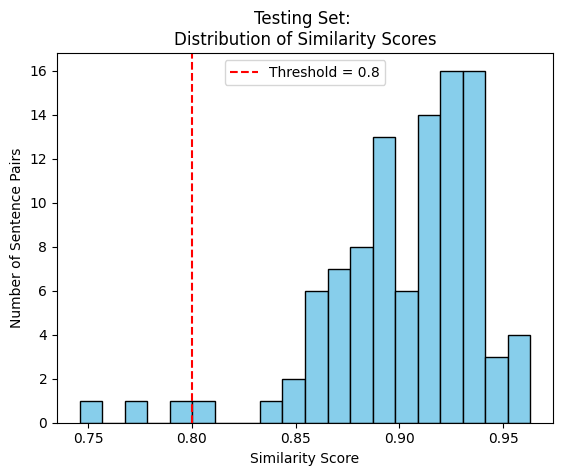

Max: 0.9631331562995911
Min: 0.7458533644676208


In [31]:
def plot_similarity_distribution(diagonal_scores_1d, split='Training Set'):
    plt.hist(diagonal_scores_1d, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(0.8, color='red', linestyle='--', label='Threshold = 0.8')
    plt.xlabel('Similarity Score')
    plt.ylabel('Number of Sentence Pairs')
    plt.title(f'{split}: \nDistribution of Similarity Scores')
    plt.legend()
    plt.show()
    
plot_similarity_distribution(train_set_diagonal_scores_1d)
print(f'Max: {np.max(train_set_diagonal_scores_1d)}')
print(f'Min: {np.min(train_set_diagonal_scores_1d)}')

plot_similarity_distribution(val_set_diagonal_scores_1d, 'Validation Set')
print(f'Max: {np.max(val_set_diagonal_scores_1d)}')
print(f'Min: {np.min(val_set_diagonal_scores_1d)}')

plot_similarity_distribution(test_set_diagonal_scores_1d, 'Testing Set')
print(f'Max: {np.max(test_set_diagonal_scores_1d)}')
print(f'Min: {np.min(test_set_diagonal_scores_1d)}')

In [32]:
# Investigate scores below threshold
for i, score in enumerate(train_set_diagonal_scores_1d):
    if score < 0.8:
        print(f'Index {i}: {score}')
        print(f"English Sentence at index {i}: {train_english_sentences[i]}")
        print(f"Afrikaans Sentence at index {i}: {train_afrikaans_sentences[i]}\n")

Index 38: 0.6659683585166931
English Sentence at index 38: In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct.
Afrikaans Sentence at index 38: In die geval van 'n katastrofiese gebeurtenis sal die kantore van die Centers for Disease Control and Prevention hulself vernietig.

Index 76: 0.7495541572570801
English Sentence at index 76: On whether a U.S. Supreme Court nominee should be forthcoming at confirmation hearings.
Afrikaans Sentence at index 76: Of 'n Amerikaanse Hooggeregshof-benoemde moet by bevestigingsverhore openlik wees.



Training set Word Cloud:


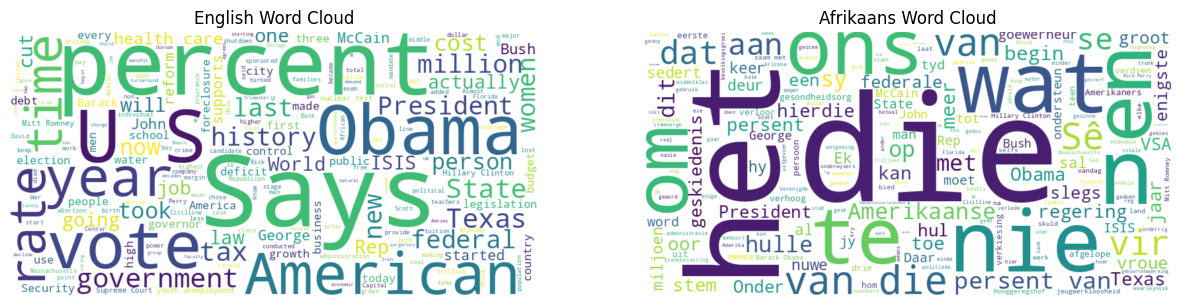

Validation set Word Cloud:


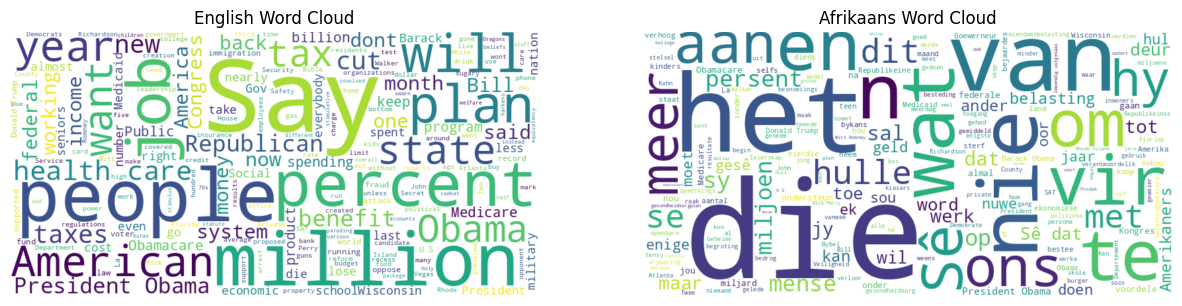

Testing set Word Cloud:


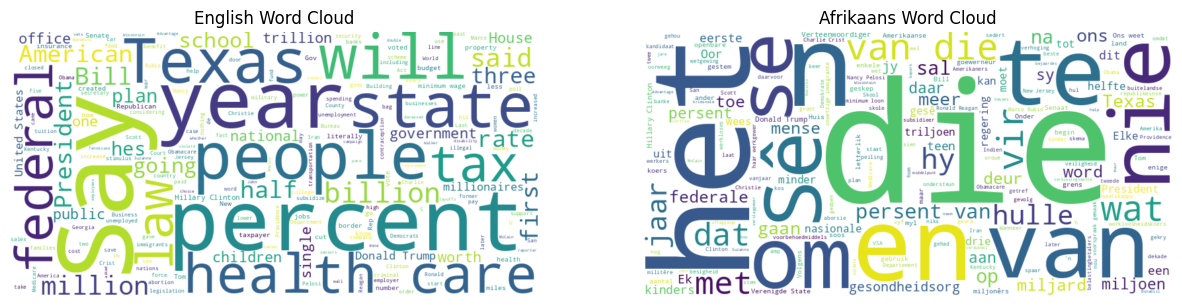

In [33]:
def create_word_cloud(english_sentences, afrikaans_sentences):
    # Creating Word Cloud
    english_text = " ".join(english_sentences)
    afrikaans_text = " ".join(afrikaans_sentences)

    # Generate the English word cloud
    english_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(english_text)

    # Generate the Afrikaans word cloud
    afrikaans_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(afrikaans_text)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    axs[0].imshow(english_wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('English Word Cloud')

    axs[1].imshow(afrikaans_wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Afrikaans Word Cloud')

    plt.show()
    
print('Training set Word Cloud:')
create_word_cloud(train_english_sentences, train_afrikaans_sentences)
    
print('Validation set Word Cloud:')
create_word_cloud(val_english_sentences, val_afrikaans_sentences)
    
print('Testing set Word Cloud:')
create_word_cloud(test_english_sentences, test_afrikaans_sentences)

#### Conclusion
The word clouds show, in some cases, a fairly accurate distributions between the English words, and their Afrikaans translations, even though some words do occur more in English than Afrikaans. The sentences that had low similarity scores have fairly accurate translations. However, the low similarity scores might be because of the unusual sentence structures, especially the second sentence in the training set.

## Comparing Gemini with Helsinki/opus-mt-en-af
Only the first 100 sentences will be compared. If there is already a clear 'winner' it is sufficient. However, if there is no clear 'winner', more sentences will be used.

In [34]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-af")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-af")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
src_lang = "en_XX"
tgt_lang = "af_ZA"
model_name = 'helsinki'

# Translate texts in batches
train_helsinki_af_translations = translate_texts_in_batches(train_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
train_helsinki_af_translations = [" ".join(words) for words in train_helsinki_af_translations]

val_helsinki_af_translations = translate_texts_in_batches(val_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
val_helsinki_af_translations = [" ".join(words) for words in val_helsinki_af_translations]

test_helsinki_af_translations = translate_texts_in_batches(test_english_sentences, None, src_lang, tgt_lang, batch_size, model_name)
test_helsinki_af_translations = [" ".join(words) for words in test_helsinki_af_translations]

In [35]:
train_english_embeddings, train_afrikaans_embeddings = calculate_similarity_scores(train_english_sentences, train_helsinki_af_translations)
val_english_embeddings, val_afrikaans_embeddings = calculate_similarity_scores(val_english_sentences, val_helsinki_af_translations)
test_english_embeddings, test_afrikaans_embeddings = calculate_similarity_scores(test_english_sentences, test_helsinki_af_translations)

train_set_sim_scores = similarity(train_english_embeddings, train_afrikaans_embeddings)
val_set_sim_scores = similarity(val_english_embeddings, val_afrikaans_embeddings)
test_set_sim_scores = similarity(test_english_embeddings, test_afrikaans_embeddings)

print('Training set with Helsinki model:')
print(train_set_sim_scores[0])

print('Validation set with Helsinki model:')
print(val_set_sim_scores[0])

print('Testing set with Helsinki model:')
print(test_set_sim_scores[0])

Training set with Helsinki model:
tensor([ 0.7871,  0.1008,  0.1616,  0.2838,  0.1217,  0.0843,  0.0965,  0.0650,
         0.0884,  0.1041,  0.1348,  0.0969,  0.1170,  0.0853,  0.0944,  0.1785,
         0.2536,  0.1419,  0.0409,  0.0808,  0.0506,  0.1122,  0.1179,  0.2682,
         0.3022,  0.0095,  0.1284,  0.1854,  0.2653,  0.1524,  0.1763,  0.0390,
         0.1043,  0.0844,  0.2122,  0.1470,  0.1606,  0.1043,  0.1632,  0.0456,
         0.1976,  0.0940,  0.0993,  0.3175,  0.0840,  0.0636,  0.1797,  0.0606,
         0.0496,  0.2145,  0.2090,  0.1808,  0.2174,  0.0970,  0.1044,  0.0745,
         0.0562, -0.0216,  0.2656,  0.1098,  0.0966,  0.1833,  0.1372,  0.0392,
         0.0419,  0.1107,  0.1370,  0.1298,  0.2371,  0.2153,  0.0341, -0.0272,
         0.2604,  0.0380,  0.0969,  0.0750,  0.2219,  0.1699,  0.3855,  0.0632,
         0.2084,  0.1501,  0.1416,  0.1859,  0.2627,  0.2201,  0.1370,  0.0930,
         0.2171,  0.1660,  0.1953,  0.0803,  0.1310,  0.2063,  0.0465,  0.2324,
      

In [36]:
# Extract the diagonal elements (similarity between each English sentence and its corresponding Afrikaans translation)
train_set_diagonal_scores = torch.diagonal(train_set_sim_scores)
val_set_diagonal_scores = torch.diagonal(val_set_sim_scores)
test_set_diagonal_scores = torch.diagonal(test_set_sim_scores)

# Convert to a 1D array
train_set_diagonal_scores_1d = train_set_diagonal_scores.tolist()
val_set_diagonal_scores_1d = val_set_diagonal_scores.tolist()
test_set_diagonal_scores_1d = test_set_diagonal_scores.tolist()

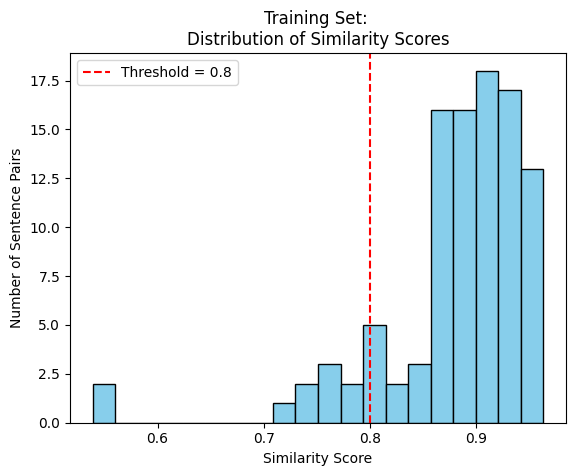

Max: 0.963884174823761
Min: 0.5387698411941528


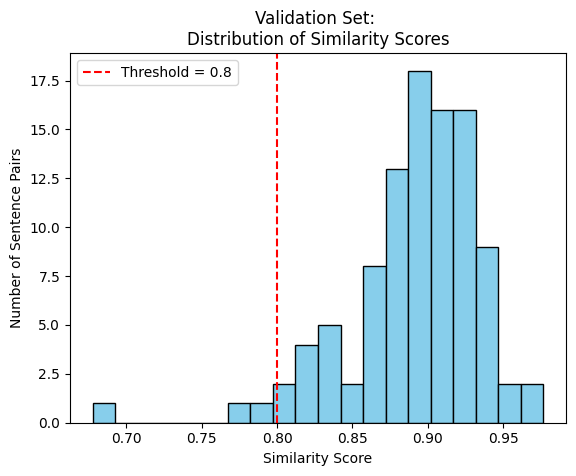

Max: 0.9766737818717957
Min: 0.6776638031005859


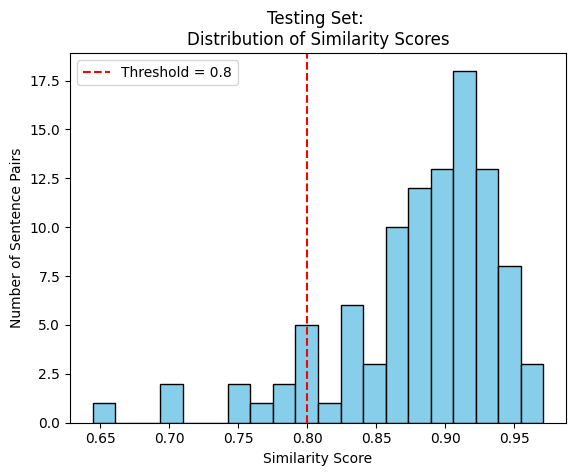

Max: 0.9713335037231445
Min: 0.6445804834365845


In [37]:
plot_similarity_distribution(train_set_diagonal_scores_1d)
print(f'Max: {np.max(train_set_diagonal_scores_1d)}')
print(f'Min: {np.min(train_set_diagonal_scores_1d)}')

plot_similarity_distribution(val_set_diagonal_scores_1d, 'Validation Set')
print(f'Max: {np.max(val_set_diagonal_scores_1d)}')
print(f'Min: {np.min(val_set_diagonal_scores_1d)}')

plot_similarity_distribution(test_set_diagonal_scores_1d, 'Testing Set')
print(f'Max: {np.max(test_set_diagonal_scores_1d)}')
print(f'Min: {np.min(test_set_diagonal_scores_1d)}')

In [38]:
# Investigate scores below threshold
for i, score in enumerate(train_set_diagonal_scores_1d):
    if score < 0.8:
        print(f'Index {i}: {score}')
        print(f"English Sentence at index {i}: {train_english_sentences[i]}")
        print(f"Afrikaans Sentence at index {i}: {train_helsinki_af_translations[i]}\n")

Index 0: 0.7870599031448364
English Sentence at index 0: Says the Annies List political group supports third-trimester abortions on demand.
Afrikaans Sentence at index 0: Volgens die Annies is daar 'n politieke groep wat derde-maande aborsies ondersteun op aanvraag.

Index 1: 0.5387698411941528
English Sentence at index 1: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
Afrikaans Sentence at index 1: Wanneer het die afname in steenkool begin?

Index 37: 0.7167805433273315
English Sentence at index 37: The nuclear test conducted in our nation this time is the Earth's 2,054th nuclear test. The five permanent members of the U.N. Security Council have conducted 99.99 percent of the total nuclear tests.
Afrikaans Sentence at index 37: Die kerntoets wat hierdie keer in ons nasie gedoen is, is die Aarde se 2 054ste kerntoets.

Index 38: 0.7620340585708618
English Sentence at index 38: In the case of 

### Conclusion
Some of these translations from the Helsinki model is truly bad, because the one sentence is only translated halfway through. Other translations also seem to translate the words directly and not translating it to its proper Afrikaans form. Therefore, the Helsinki model performs worse than Gemini for these translations. It is important to note that the Helsinki model might perform better on other corpora, but in this case it did not perform too well compared to the Gemini model.

<hr>

# BERT
### Acknowledgements

#### **Source/Model:** [google-bert/bert-base-multilingual-cased](https://huggingface.co/google-bert/bert-base-multilingual-cased)

#### **Description:** _(more details available on the source page)_

BERT is a language model trained on a massive amount of text data. It's unique because it doesn't need humans to label the data. Instead, it learns from the text itself using a process called self-supervised learning.

BERT learns in two ways:
- Masked Language Modeling: It hides some words in a sentence and tries to guess what they are. This helps it understand the context and relationships between words.
- Next Sentence Prediction: It determines if two sentences are connected or not. This helps it understand sentence structure and relationships.

After training, BERT can be used to analyze and understand new text. For example, you can use it to classify text into different categories or extract important information.

**Reference:**  "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" by Devlin et al. (2018).

### Encode labels

In [39]:
# Initialise the encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training set and transform all sets
train_merged_df['Afrikaans Labels Encoded'] = label_encoder.fit_transform(train_merged_df['Afrikaans Labels'])
val_merged_df['Afrikaans Labels Encoded'] = label_encoder.transform(val_merged_df['Afrikaans Labels'])
test_merged_df['Afrikaans Labels Encoded'] = label_encoder.transform(test_merged_df['Afrikaans Labels'])

# Display the updated DataFrame with encoded labels
print(train_merged_df[['Afrikaans Labels', 'Afrikaans Labels Encoded']])

     Afrikaans Labels  Afrikaans Labels Encoded
0                vals                         4
1           half-waar                         1
2        meestal-waar                         2
3                vals                         4
4           half-waar                         1
...               ...                       ...
9985     meestal-waar                         2
9986             waar                         5
9987             waar                         5
9988       broek-vuur                         0
9989        half-waar                         1

[9990 rows x 2 columns]


In [40]:
def preprocess_text(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    return encoded_input

def extract_embeddings(encoded_input):
    with torch.no_grad():
        outputs = model(**encoded_input)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings

# Load BERT model and tokenizer via HuggingFace Transformers
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [41]:
# Preprocess text
training_inputs = [preprocess_text(str(text)) for text in train_merged_df['Afrikaans Sentence']]
validation_inputs = [preprocess_text(str(text)) for text in val_merged_df['Afrikaans Sentence']]
testing_inputs = [preprocess_text(str(text)) for text in test_merged_df['Afrikaans Sentence']]

In [42]:
# Preprocess and extract embeddings
def get_embeddings(texts):
    inputs = [preprocess_text(text) for text in texts]
    embeddings = [extract_embeddings(sample) for sample in inputs]
    return np.array(embeddings)

# Check if the "bert_af_embeddings" folder exists
if not os.path.exists("../data/bert-af-embeddings"):
    os.makedirs("../data/bert-af-embeddings")

# Check if the embedding files exist
train_embedding_file = "../data/bert-af-embeddings/train_af_embeddings.npy"
val_embedding_file = "../data/bert-af-embeddings/val_af_embeddings.npy"
test_embedding_file = "../data/bert-af-embeddings/test_af_embeddings.npy"

if not os.path.exists(train_embedding_file) or not os.path.exists(val_embedding_file) or not os.path.exists(test_embedding_file):
    # Extract embeddings
    training_embeddings = get_embeddings(train_merged_df['Afrikaans Sentence'])
    validation_embeddings = get_embeddings(val_merged_df['Afrikaans Sentence'])
    testing_embeddings = get_embeddings(test_merged_df['Afrikaans Sentence'])
    
    # Change file path
    train_embedding_output_file = "../data/output/bert-af-embeddings/train_af_embeddings.npy"
    val_embedding_output_file = "../data/output/bert-af-embeddings/val_af_embeddings.npy"
    test_embedding_output_file = "../data/output/bert-af-embeddings/test_af_embeddings.npy"

    # Save embeddings to files
    np.save(train_embedding_output_file, training_embeddings)
    np.save(val_embedding_output_file, validation_embeddings)
    np.save(test_embedding_output_file, testing_embeddings)

# Load embeddings from files if they exist
else:
    training_embeddings = np.load(train_embedding_file)
    validation_embeddings = np.load(val_embedding_file)
    testing_embeddings = np.load(test_embedding_file)

# Extract features
X_train = training_embeddings
X_val = validation_embeddings
X_test = testing_embeddings

In [43]:
# Extract labels
y_train = train_merged_df['Afrikaans Labels Encoded']
y_val = val_merged_df['Afrikaans Labels Encoded']
y_test = test_merged_df['Afrikaans Labels Encoded']

In [44]:
print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

Training labels distribution: Counter({1: 2060, 4: 1947, 2: 1913, 5: 1635, 3: 1621, 0: 814})
Validation labels distribution: Counter({4: 262, 2: 251, 1: 248, 3: 236, 5: 169, 0: 116})
Test labels distribution: Counter({1: 264, 4: 248, 2: 241, 3: 210, 5: 207, 0: 92})


# Random Forest Classification

In [45]:
# # Initialise Random Forest Classifier
# rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)

# # Train the classifier
# rf_clf.fit(X_train, y_train)

# # Predict on validation set
# rf_pred = rf_clf.predict(X_val)

# # Evaluate
# print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
# print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# # Predict on testing set
# rf_test = rf_clf.predict(X_test)

# # Test
# print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
# print("Testing Classification Report:\n", classification_report(y_test, rf_test))

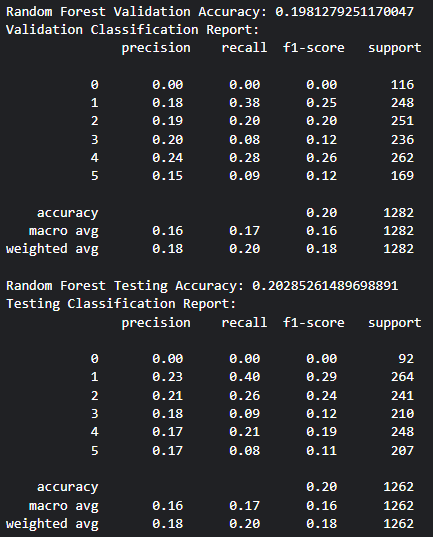_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
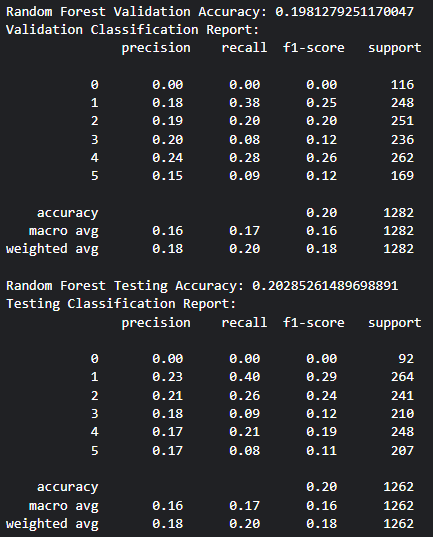

# Logistic Regression Classification
Logistic Regression with Standard Scaling

In [46]:
# # Initialise Logistic Regression Classifier
# lr_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed, multi_class='multinomial', solver='lbfgs'))

# # Train the classifier
# lr_clf.fit(X_train, y_train)

# # Predict on validation set
# lr_pred = lr_clf.predict(X_val)

# # Evaluate
# print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
# print("Validation Classification Report:\n", classification_report(y_val, lr_pred))

# # Predict on testing set
# lr_test = lr_clf.predict(X_test)

# # Test
# print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, lr_test))
# print("Testing Classification Report:\n", classification_report(y_test, lr_test))

_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
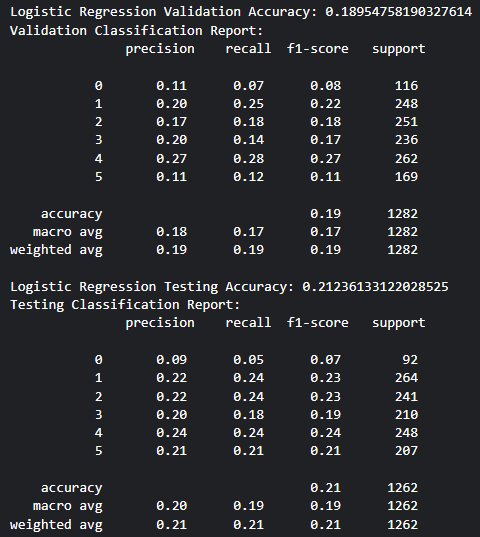

# SVM Classification
SVM with Standard Scaling

In [47]:
# from sklearn.svm import SVC

# # Initialise SVM Classifier
# svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))

# # Train the classifier
# svm_clf.fit(X_train, y_train)

# # Predict on validation set
# svm_pred = svm_clf.predict(X_val)

# # Evaluate
# print("SVM Validation Accuracy:", accuracy_score(y_val, svm_pred))
# print("Validation Classification Report:\n", classification_report(y_val, svm_pred))

# # Predict on testing set
# svm_test = svm_clf.predict(X_test)

# # Test
# print("SVM Testing Accuracy:", accuracy_score(y_test, svm_test))
# print("Testing Classification Report:\n", classification_report(y_test, svm_test))

_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
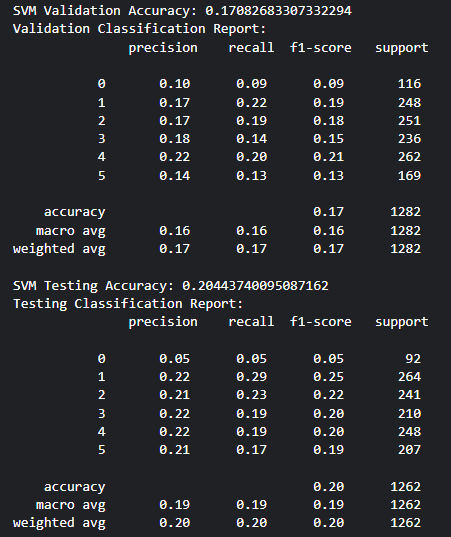

# Data Update

The classification models seem to struggle with the six-way classification. The accuracy scores are only around 20% which seems to be a common theme when using the LIAR dataset with all 6 labels. A recent paper (September 2024, Are Strong Baselines Enough? False News Detection with Machine Learning) by Aslan et. al experimented with this dataset by manipulating the class labels from six classes to two classes. They've done it using 5 different approaches:

1. All labels except "true" are labeled as "false".
2. Labels "pants-fire" and "false" are labeled as "false" and the rest as "true".
3. All labels except "pants-fire" are labeled as "true".
4. Labels are split from the middle into "true" and "false".
5. Labels "true" and "mostly-true" are labeled as "true" and the rest as "false".

They found that option 3 were the best approach as it achieved 91% accuracy. Therefore, for this study we will be using their approach (only using the corresponding Afrikaans labels) to classify the Afrikaans data using only two classes (True or False), as specified in option 3.

**Source:** [Are Strong Baselines Enough? False News Detection with Machine Learning](https://doi.org/10.3390/fi16090322)

**BibTeX Citation:**
```
@Article{fi16090322,
AUTHOR = {Aslan, Lara and Ptaszynski, Michal and Jauhiainen, Jukka},
TITLE = {Are Strong Baselines Enough? False News Detection with Machine Learning},
JOURNAL = {Future Internet},
VOLUME = {16},
YEAR = {2024},
NUMBER = {9},
ARTICLE-NUMBER = {322},
URL = {https://www.mdpi.com/1999-5903/16/9/322},
ISSN = {1999-5903},
ABSTRACT = {False news refers to false, fake, or misleading information presented as real news. In recent years, there has been a noticeable increase in false news on the Internet. The goal of this paper was to study the automatic detection of such false news using machine learning and natural language processing techniques and to determine which techniques work the most effectively. This article first studies what constitutes false news and how it differs from other types of misleading information. We also study the results achieved by other researchers on the same topic. After building a foundation to understand false news and the various ways of automatically detecting it, this article provides its own experiments. These experiments were carried out on four different datasets, one that was made just for this article, using 10 different machine learning methods. The results of this article were satisfactory and provided answers to the original research questions set up at the beginning of this article. This article could determine from the experiments that passive aggressive algorithms, support vector machines, and random forests are the most efficient methods for automatic false news detection. This article also concluded that more complex experiments, such as using multiple levels of identifying false news or detecting computer-generated false news, require more complex machine learning models.},
DOI = {10.3390/fi16090322}
}
```


#### Change and Encode the new labels using binary encoding

In [48]:
# Copy existing dataframes
new_train_merged_df = train_merged_df.copy()
new_val_merged_df = val_merged_df.copy()
new_test_merged_df = test_merged_df.copy()

# Change the existing labels to binary (1 for if it's not 'broek-vuur', 0 for 'broek-vuur') (OPTION 3)
new_train_merged_df['New Afrikaans Labels'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded  New Afrikaans Labels  
0                vals                         4                     1  
1           half-waar                         1                     1  
2        meestal-waar                         2                     1  
3                vals                         4                     1  
4           half-waar                         1                     1  
...               ...                       ...                   ...  
9985     meestal-waar                         2                     1  
9986             waar                         5                     1  
9987             waar                         5                     1  
9988       broek-vuur                         0                     0  
9989        half-waar                         1                     1  

[9990 rows x 7 columns]

In [49]:
new_train_merged_df['New Afrikaans Labels Encoded'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels Encoded'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels Encoded'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded  New Afrikaans Labels  \
0                vals                         4                     1   
1           half-waar                         1                     1   
2        meestal-waar                         2                     1   
3                vals                         4                     1   
4           half-waar                         1                     1   
...               ...                       ...                   ...   
9985     meestal-waar                         2                     1   
9986             waar                         5                     1   
9987             waar                         5                     1   
9988       broek-vuur                         0                     0   
9989        half-waar                         1                     1   

      New Afrikaans Labels Encoded  
0                                1  
1                                1  
2                                1  
3                                1  
4                                1  
...                            ...  
9985                             1  
9986                             1  
9987                             1  
9988                             0  
9989                             1  

[9990 rows x 8 columns]

In [50]:
# Update 'New Afrikaans Labels' column in all three dataframes based on the condition
new_train_merged_df['New Afrikaans Labels'] = np.where(new_train_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')
new_val_merged_df['New Afrikaans Labels'] = np.where(new_val_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')
new_test_merged_df['New Afrikaans Labels'] = np.where(new_test_merged_df['New Afrikaans Labels'] == 1, 'waar', 'vals')

# Display the updated DataFrame
new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded New Afrikaans Labels  \
0                vals                         4                 waar   
1           half-waar                         1                 waar   
2        meestal-waar                         2                 waar   
3                vals                         4                 waar   
4           half-waar                         1                 waar   
...               ...                       ...                  ...   
9985     meestal-waar                         2                 waar   
9986             waar                         5                 waar   
9987             waar                         5                 waar   
9988       broek-vuur                         0                 vals   
9989        half-waar                         1                 waar   

      New Afrikaans Labels Encoded  
0                                1  
1                                1  
2                                1  
3                                1  
4                                1  
...                            ...  
9985                             1  
9986                             1  
9987                             1  
9988                             0  
9989                             1  

[9990 rows x 8 columns]

In [51]:
# Update 'New Afrikaans Labels' column in all three dataframes based on the condition
new_train_merged_df['New English Labels'] = np.where(new_train_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')
new_val_merged_df['New English Labels'] = np.where(new_val_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')
new_test_merged_df['New English Labels'] = np.where(new_test_merged_df['New Afrikaans Labels'] == 'waar', 'true', 'false')

# Display the updated DataFrame
new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded New Afrikaans Labels  \
0                vals                         4                 waar   
1           half-waar                         1                 waar   
2        meestal-waar                         2                 waar   
3                vals                         4                 waar   
4           half-waar                         1                 waar   
...               ...                       ...                  ...   
9985     meestal-waar                         2                 waar   
9986             waar                         5                 waar   
9987             waar                         5                 waar   
9988       broek-vuur                         0                 vals   
9989        half-waar                         1                 waar   

      New Afrikaans Labels Encoded New English Labels  
0                                1               true  
1                                1               true  
2                                1               true  
3                                1               true  
4                                1               true  
...                            ...                ...  
9985                             1               true  
9986                             1               true  
9987                             1               true  
9988                             0              false  
9989                             1               true  

[9990 rows x 9 columns]

In [52]:
csv_new_train_merged_df = pd.merge(train_df, new_train_merged_df, how='left', left_index=True, right_index=True)
csv_new_val_merged_df = pd.merge(val_df, new_val_merged_df, how='left', left_index=True, right_index=True)
csv_new_test_merged_df = pd.merge(test_df, new_test_merged_df, how='left', left_index=True, right_index=True)

In [53]:
csv_new_train_merged_df = csv_new_train_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_val_merged_df = csv_new_val_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_test_merged_df = csv_new_test_merged_df.drop(columns=['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels Encoded', 'New Afrikaans Labels Encoded'])
csv_new_train_merged_df

ID        Label  \
0       2635.json        false   
1      10540.json    half-true   
2        324.json  mostly-true   
3       1123.json        false   
4       9028.json    half-true   
...           ...          ...   
10235   5473.json  mostly-true   
10236   3408.json  mostly-true   
10237   3959.json    half-true   
10238   2253.json        false   
10239   1155.json   pants-fire   

                                               Statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                               Subject(s)         Speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           Job Title State Info  \
0                               State representative      Texas   
1                                     State delegate   Virginia   
2                                          President   Illinois   
3                                                NaN        NaN   
4                                                NaN    Florida   
...                                              ...        ...   
10235                                            NaN    Florida   
10236                                            NaN    Georgia   
10237                                            NaN    Georgia   
10238                                            NaN    Florida   
10239  chairman of the Republican National Committee   Maryland   

      Party Affiliation  Barely True Counts  False Counts  Half True Counts  \
0            republican                 0.0           1.0               0.0   
1              democrat                 0.0           0.0               1.0   
2              democrat                70.0          71.0             160.0   
3                  none                 7.0          19.0               3.0   
4              democrat                15.0           9.0              20.0   
...                 ...                 ...           ...               ...   
10235              none                 0.0           1.0               1.0   
10236        republican                 0.0           0.0               0.0   
10237        republican                 4.0          11.0               5.0   
10238          democrat                 3.0           1.0               3.0   
10239        republican                 0.0           1.0               1.0   

       Mostly True Counts  Pants on fire Counts  \
0                     0.0                   0.0   
1                     1.0                   0.0   
2                   163.0                   9.0   
3                     5.0                  44.0   
4                    19.0                   2.0   
...                   ...                   ...   
10235                 1.0                

In [54]:
os.makedirs('../data/new_liar_dataset/train', exist_ok=True)
os.makedirs('../data/new_liar_dataset/val', exist_ok=True)
os.makedirs('../data/new_liar_dataset/test', exist_ok=True)

# Save DataFrames as CSV files
csv_new_train_merged_df.to_csv('../data/new_liar_dataset/train/train_data.csv', header=False)
csv_new_val_merged_df.to_csv('../data/new_liar_dataset/val/val_data.csv', header=False)
csv_new_test_merged_df.to_csv('../data/new_liar_dataset/test/test_data.csv', header=False)

In [55]:
new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded New Afrikaans Labels  \
0                vals                         4                 waar   
1           half-waar                         1                 waar   
2        meestal-waar                         2                 waar   
3                vals                         4                 waar   
4           half-waar                         1                 waar   
...               ...                       ...                  ...   
9985     meestal-waar                         2                 waar   
9986             waar                         5                 waar   
9987             waar                         5                 waar   
9988       broek-vuur                         0                 vals   
9989        half-waar                         1                 waar   

      New Afrikaans Labels Encoded New English Labels  
0                                1               true  
1                                1               true  
2                                1               true  
3                                1               true  
4                                1               true  
...                            ...                ...  
9985                             1               true  
9986                             1               true  
9987                             1               true  
9988                             0              false  
9989                             1               true  

[9990 rows x 9 columns]

In [56]:
unwanted_columns = ['New Afrikaans Labels', 'New English Labels']

new_train_merged_df = new_train_merged_df.drop(columns=unwanted_columns, axis=1)
new_val_merged_df = new_val_merged_df.drop(columns=unwanted_columns, axis=1)
new_test_merged_df = new_test_merged_df.drop(columns=unwanted_columns, axis=1)

new_train_merged_df

Index                                 Afrikaans Sentence  \
0         0  Die politieke groep Annies List sê dat hulle a...   
1         1  Wanneer het die afname van steenkool begin? Di...   
2         2  Hillary Clinton stem saam met John McCain "deu...   
3         3  Gesondheidsorg-hervormingswetgewing sal waarsk...   
4         4  Ekonomiese oplewing het aan die einde van my a...   
...     ...                                                ...   
9985   9995  Die Republikeine het herhaaldelik gesê dat hul...   
9986   9996  'n Deeltydse Kongreslid met die helfte van die...   
9987   9997  Ongeveer 40 persent van sy kiesers in die McAl...   
9988   9998  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989   9999  Hy sê Barack Obama is met genot gefotografeer ...   

                                       English Sentence English Labels  \
0     Says the Annies List political group supports ...          false   
1     When did the decline of coal start? It started...      half-true   
2     Hillary Clinton agrees with John McCain "by vo...    mostly-true   
3     Health care reform legislation is likely to ma...          false   
4     The economic turnaround started at the end of ...      half-true   
...                                                 ...            ...   
9985  The Castro regime violated international norms...    mostly-true   
9986  Theres not one Democrat who endorses the Romne...           true   
9987  The United States death rate is two-and-a-half...           true   
9988  Says that Tennessee Gov. Bill Haslam has made ...     pants-fire   
9989    Donald Trump says hed deport 16 million people.      half-true   

     Afrikaans Labels  Afrikaans Labels Encoded  New Afrikaans Labels Encoded  
0                vals                         4                             1  
1           half-waar                         1                             1  
2        meestal-waar                         2                             1  
3                vals                         4                             1  
4           half-waar                         1                             1  
...               ...                       ...                           ...  
9985     meestal-waar                         2                             1  
9986             waar                         5                             1  
9987             waar                         5                             1  
9988       broek-vuur                         0                             0  
9989        half-waar                         1                             1  

[9990 rows x 7 columns]

#### Update extracted labels

In [57]:
# Extract labels
y_train = new_train_merged_df['New Afrikaans Labels Encoded']
y_val = new_val_merged_df['New Afrikaans Labels Encoded']
y_test = new_test_merged_df['New Afrikaans Labels Encoded']

print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

Training labels distribution: Counter({1: 9176, 0: 814})
Validation labels distribution: Counter({1: 1166, 0: 116})
Test labels distribution: Counter({1: 1170, 0: 92})


#### Balance the training data

In [58]:
# Instantiate SMOTE
smote = SMOTE(random_state=seed)

# Apply SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new distribution
from collections import Counter
print(f'New training labels distribution: {Counter(y_train_balanced)}')

New training labels distribution: Counter({1: 9176, 0: 9176})


# Random Forest Classification

In [59]:
# Initialise Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Train the classifier
rf_clf.fit(X_train_balanced, y_train_balanced)

# Predict on validation set
rf_pred = rf_clf.predict(X_val)

# Evaluate
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# Predict on testing set
rf_test = rf_clf.predict(X_test)

# Test
print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
print("Testing Classification Report:\n", classification_report(y_test, rf_test))

Random Forest Validation Accuracy: 0.9017160686427457
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.91      0.99      0.95      1166

    accuracy                           0.90      1282
   macro avg       0.45      0.50      0.47      1282
weighted avg       0.83      0.90      0.86      1282

Random Forest Testing Accuracy: 0.919175911251981
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.01      0.02        92
           1       0.93      0.99      0.96      1170

    accuracy                           0.92      1262
   macro avg       0.51      0.50      0.49      1262
weighted avg       0.87      0.92      0.89      1262



_Note the following is an image from the Random Forest classification report. This allows us to not having to run the classifier every time to view the results._
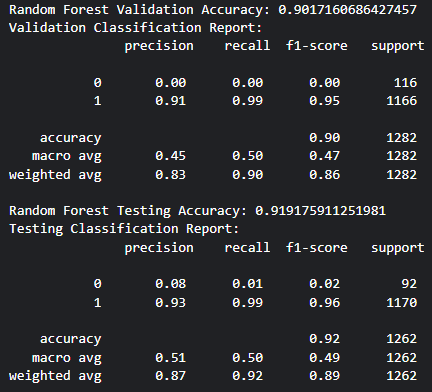

# Logistic Regression Classification
Logistic Regression with Standard Scaling

In [60]:
# # Initialise Logistic Regression Classifier
# lr_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=seed, multi_class='multinomial', solver='lbfgs'))

# # Train the classifier
# lr_clf.fit(X_train_balanced, y_train_balanced)

# # Predict on validation set
# lr_pred = lr_clf.predict(X_val)

# # Evaluate
# print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, lr_pred))
# print("Validation Classification Report:\n", classification_report(y_val, lr_pred))

# # Predict on testing set
# lr_test = lr_clf.predict(X_test)

# # Test
# print("Logistic Regression Testing Accuracy:", accuracy_score(y_test, lr_test))
# print("Testing Classification Report:\n", classification_report(y_test, lr_test))

_Note the following is an image from the Logistic Regression classification report. This allows us to not having to run the classifier every time to view the results._
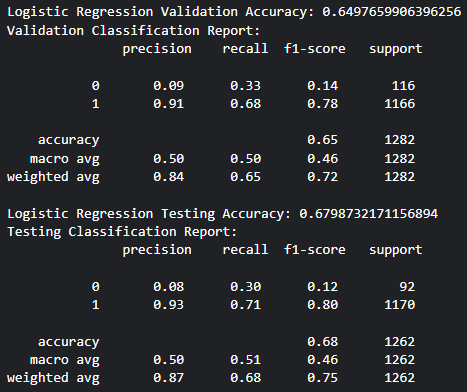

# SVM Classification
SVM with Standard Scaling

In [61]:
# # Initialise SVM Classifier
# svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))

# # Train the classifier
# svm_clf.fit(X_train_balanced, y_train_balanced)

# # Predict on validation set
# svm_pred = svm_clf.predict(X_val)

# # Evaluate
# print("SVM Validation Accuracy:", accuracy_score(y_val, svm_pred))
# print("Validation Classification Report:\n", classification_report(y_val, svm_pred))

# # Predict on testing set
# svm_test = svm_clf.predict(X_test)

# # Test
# print("SVM Testing Accuracy:", accuracy_score(y_test, svm_test))
# print("Testing Classification Report:\n", classification_report(y_test, svm_test))

_Note the following is an image from the SVM classification report. This allows us to not having to run the classifier every time to view the results._
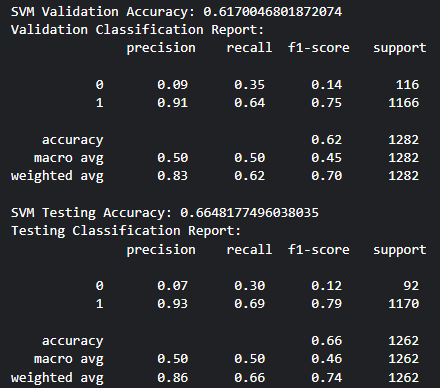

From the classification results we clearly see that the Random Forest classifier achieved the best scores. Therefore, we will use its predictions.

# LIME ( Local Interpretable Model-agnostic Explanations )

In [62]:
lime_train_df = new_train_merged_df.copy()
lime_train_df = lime_train_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_train_df

Afrikaans Sentence  \
0     Die politieke groep Annies List sê dat hulle a...   
1     Wanneer het die afname van steenkool begin? Di...   
2     Hillary Clinton stem saam met John McCain "deu...   
3     Gesondheidsorg-hervormingswetgewing sal waarsk...   
4     Ekonomiese oplewing het aan die einde van my a...   
...                                                 ...   
9985  Die Republikeine het herhaaldelik gesê dat hul...   
9986  'n Deeltydse Kongreslid met die helfte van die...   
9987  Ongeveer 40 persent van sy kiesers in die McAl...   
9988  Minnesota, Michigan en Iowa het reeds ŉ snelhe...   
9989  Hy sê Barack Obama is met genot gefotografeer ...   

      New Afrikaans Labels Encoded  
0                                1  
1                                1  
2                                1  
3                                1  
4                                1  
...                            ...  
9985                             1  
9986                             1  
9987                             1  
9988                             0  
9989                             1  

[9990 rows x 2 columns]

In [63]:
lime_val_df = new_val_merged_df.copy()
lime_val_df = lime_val_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_val_df

Afrikaans Sentence  \
0     Ons het nou minder Amerikaners in diens as in ...   
1     Toe Obama ingehuldig is, het hy NIE die Heilig...   
2     Sê dat organisasies wat as liefdadigheidsorgan...   
3      Sê byna helfte van die kinders in Oregon is arm.   
4     Oor aanvalle deur Republikeine dat verskeie pr...   
...                                                 ...   
1277  In die afgelope twee jaar het Demokrate meer g...   
1278  Vir die eerste keer in meer as 'n dekade was i...   
1279  Sê Donald Trump het sy maatskappye nie een nie...   
1280  John McCain en George Bush het "heeltemal geen...   
1281  'n Nuwe meningspeiling wys dat 62 persent die ...   

      New Afrikaans Labels Encoded  
0                                1  
1                                0  
2                                1  
3                                1  
4                                1  
...                            ...  
1277                             0  
1278                             1  
1279                             1  
1280                             1  
1281                             1  

[1282 rows x 2 columns]

In [64]:
lime_test_df = new_test_merged_df.copy()
lime_test_df = lime_test_df.drop(['Index', 'English Sentence', 'English Labels', 'Afrikaans Labels', 'Afrikaans Labels Encoded'], axis=1)
lime_test_df

Afrikaans Sentence  \
0     Om 'n muur op die VSA.-Meksiko-grens te bou, s...   
1     Wisconsin is op koers om vanjaar die aantal af...   
2     Hy sê dat John McCain niks gedoen het om die s...   
3     Suzanne Bonamici ondersteun 'n plan wat Medica...   
4     Toe 'n verslaggewer hom gevra het of hy in die...   
...                                                 ...   
1257  Sen. Bob Menendez het gestem vir die implement...   
1258  Sê sy begroting voorsien vir die hoogste vlak ...   
1259                         Ek was amper elke dag hier   
1260  In die vroeë 1990's het Sen. Edward Kennedy he...   
1261  Die VSA sê 'n EPA-permit het onder Strickland ...   

      New Afrikaans Labels Encoded  
0                                1  
1                                1  
2                                1  
3                                1  
4                                0  
...                            ...  
1257                             1  
1258                             1  
1259                             0  
1260                             1  
1261                             1  

[1262 rows x 2 columns]

In [65]:
def get_feature_names(dataframe_row):
    return dataframe_row.split(' ')   

In [66]:
get_feature_names(lime_train_df.iloc[0, 0])

['Die',
 'politieke',
 'groep',
 'Annies',
 'List',
 'sê',
 'dat',
 'hulle',
 'aborsies',
 'op',
 'aanvraag',
 'in',
 'die',
 'derde',
 'trimester',
 'ondersteun.']

#### Create a pipeline from the previous models (i.e. BERT, Random Forest) with the LIME model

In [67]:
class BertEmbeddingExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_file=None, set_split=None, model_name='bert-base-multilingual-cased', random_state=99):
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.eval()  # Set model to evaluation mode
        self.embeddings = None
        self.embedding_file = embedding_file
        self.set_split = set_split
        self.random_state = random_state

    def transform(self, texts, y=None, embedding_file=None, set_split=None):
        # If no embedding file is provided, raise an error
        if self.embedding_file is None and embedding_file is None:
            raise ValueError("An embedding file must be provided.")
            
        # If no set split is specified, raise an error
        if self.set_split is None and set_split is None:
            raise ValueError("The dataset split should be specified (e.g. 'train').")
        
        # Handle cases for validation and testing files
        if self.embedding_file != embedding_file and embedding_file is not None:
            self.embedding_file = embedding_file
            
        if self.set_split != set_split and set_split is not None:
            self.set_split = set_split

        # Check if the embedding file exists
        if os.path.exists(self.embedding_file):            
            self.embeddings = np.load(self.embedding_file)
            print(f"Loaded existing embeddings from {self.embedding_file}.")
            
            # Apply SMOTE if in 'train' set
            if self.set_split == 'train' and y is not None:
                print(f"Balancing embeddings for training set with SMOTE.")
                smote = SMOTE(random_state=self.random_state)
                X_balanced, y_balanced = smote.fit_resample(self.embeddings, y)
                self.embeddings = X_balanced
                return X_balanced, y_balanced
            
            return self.embeddings

        # If embeddings need to be extracted
        embeddings = []
        for text in texts:
            encoded_input = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
            with torch.no_grad():  # Disable gradient calculation
                outputs = self.model(**encoded_input)
                # Extract the mean of the last hidden states
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(embedding)
        
        self.embeddings = np.array(embeddings)
        embedding_output_file = f"..data/output/bert-af-embeddings/{self.set_split}_af_embeddings.npy"
        np.save(embedding_output_file, self.embeddings)  # Save embeddings to file
        print(f"Extracted and saved new embeddings to {embedding_output_file}.")
        
        # Apply SMOTE if in 'train' set
        if self.set_split == 'train' and y is not None:
            print(f"Balancing embeddings for training set with SMOTE.")
            smote = SMOTE(random_state=self.random_state)
            X_balanced, y_balanced = smote.fit_resample(self.embeddings, y)
            self.embeddings = X_balanced
            return X_balanced, y_balanced
        
        return self.embeddings

    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer

In [68]:
# Copy existing dataframes
new_train_merged_df = train_merged_df.copy()
new_val_merged_df = val_merged_df.copy()
new_test_merged_df = test_merged_df.copy()

# Change the existing labels to binary (1 for if it's not 'broek-vuur', 0 for 'broek-vuur')
new_train_merged_df['New Afrikaans Labels Encoded'] = (new_train_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_val_merged_df['New Afrikaans Labels Encoded'] = (new_val_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)
new_test_merged_df['New Afrikaans Labels Encoded'] = (new_test_merged_df['Afrikaans Labels'] != 'broek-vuur').astype(int)

# Extract labels
y_train = new_train_merged_df['New Afrikaans Labels Encoded']
y_val = new_val_merged_df['New Afrikaans Labels Encoded']
y_test = new_test_merged_df['New Afrikaans Labels Encoded']

print("Training labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

Training labels distribution: Counter({1: 9176, 0: 814})
Validation labels distribution: Counter({1: 1166, 0: 116})
Test labels distribution: Counter({1: 1170, 0: 92})


In [69]:
# Define embedding file paths
train_embedding_input_file = "../data/bert-af-embeddings/train_af_embeddings.npy"
val_embedding_input_file = "../data/bert-af-embeddings/val_af_embeddings.npy"
test_embedding_input_file = "../data/bert-af-embeddings/test_af_embeddings.npy"

# Initialise the extractor
bert_extractor = BertEmbeddingExtractor()

# Ensure output directory exists
output_dir = "../data/output/bert-af-embeddings"
os.makedirs(output_dir, exist_ok=True)

# Extract embeddings for each dataset
training_embeddings, y_train_balanced = bert_extractor.transform(new_train_merged_df['Afrikaans Sentence'], y_train, train_embedding_input_file, 'train')
validation_embeddings = bert_extractor.transform(new_val_merged_df['Afrikaans Sentence'], None, val_embedding_input_file, 'val')
testing_embeddings = bert_extractor.transform(new_test_merged_df['Afrikaans Sentence'], None, test_embedding_input_file, 'test')

Loaded existing embeddings from /kaggle/input/bert-af-embeddings/train_af_embeddings.npy.
Balancing embeddings for training set with SMOTE.
Loaded existing embeddings from /kaggle/input/bert-af-embeddings/val_af_embeddings.npy.
Loaded existing embeddings from /kaggle/input/bert-af-embeddings/test_af_embeddings.npy.


In [70]:
# Extract features
X_train_balanced = training_embeddings
X_val = validation_embeddings
X_test = testing_embeddings

print("Training labels distribution:", Counter(y_train_balanced))
print("Validation labels distribution:", Counter(y_val))
print("Test labels distribution:", Counter(y_test))

Training labels distribution: Counter({1: 9176, 0: 9176})
Validation labels distribution: Counter({1: 1166, 0: 116})
Test labels distribution: Counter({1: 1170, 0: 92})


In [71]:
# Initialize Random Forest Classifier 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

class BertEmbeddingPipeline:
    def __init__(self, embedding_file, set_split, classifier):
        self.bert_extractor = BertEmbeddingExtractor(embedding_file, set_split)
        self.classifier = classifier
        self.embedding_file = embedding_file
        self.set_split = set_split

    def fit(self, X, y, is_balanced=False):
        # Set the embedding file and split for training
        self.bert_extractor.embedding_file = self.bert_extractor.embedding_file
        self.bert_extractor.set_split = self.bert_extractor.set_split
        
        if is_balanced == False:
            # Extract embeddings for training data
            self.embeddings, balanced_y = self.bert_extractor.transform(X, y)
            self.classifier.fit(self.embeddings, balanced_y)
        else:
            self.embeddings = X
            self.classifier.fit(self.embeddings, y)

    def predict(self, X, embedding_file=None, set_split=None):
        if embedding_file is None:
            embedding_file = self.embedding_file
        
        if set_split is None:
            set_split = self.set_split
            
        # Set the embedding file and split for prediction
        self.bert_extractor.embedding_file = embedding_file
        self.bert_extractor.set_split = set_split
        embeddings = self.bert_extractor.transform(X)
        return self.classifier.predict(embeddings)

# Create a custom pipeline instance
pipeline = BertEmbeddingPipeline(train_embedding_input_file, 'train', rf_clf)

# Fit the classifier on training set
pipeline.fit(X_train_balanced, y_train_balanced, is_balanced=True)

# Predict on validation set
rf_pred = pipeline.predict(new_val_merged_df['Afrikaans Sentence'], val_embedding_input_file, 'val')

# Evaluate on validation set
print("Random Forest Validation Accuracy:", accuracy_score(y_val, rf_pred))
print("Validation Classification Report:\n", classification_report(y_val, rf_pred))

# Predict on testing set
rf_test = pipeline.predict(new_test_merged_df['Afrikaans Sentence'], test_embedding_input_file, 'test')

# Test on the test set
print("Random Forest Testing Accuracy:", accuracy_score(y_test, rf_test))
print("Testing Classification Report:\n", classification_report(y_test, rf_test))

Loaded existing embeddings from /kaggle/input/bert-af-embeddings/val_af_embeddings.npy.
Random Forest Validation Accuracy: 0.9024960998439937
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.91      0.99      0.95      1166

    accuracy                           0.90      1282
   macro avg       0.45      0.50      0.47      1282
weighted avg       0.83      0.90      0.86      1282

Loaded existing embeddings from /kaggle/input/bert-af-embeddings/test_af_embeddings.npy.
Random Forest Testing Accuracy: 0.9199683042789224
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.01      0.02        92
           1       0.93      0.99      0.96      1170

    accuracy                           0.92      1262
   macro avg       0.51      0.50      0.49      1262
weighted avg       0.87      0.92      0.89      126

In [72]:
def explain_prediction(pipeline, text, embedding_file, set_split, num_samples):
    # Use LIME to explain the prediction
    print('Getting LIME explanation...\n')
    
    # Function to predict probabilities for LIME
    def predict_proba_fn(texts):
        # Generate embeddings
        embeddings = pipeline.bert_extractor.transform(texts, embedding_file, set_split)
        print(f"Embeddings shape: {embeddings.shape}")
        
        return pipeline.classifier.predict_proba(embeddings)

    # Initialise LIME Text Explainer
    explainer = LimeTextExplainer(class_names=['Misinformation', 'Truthful'])

    # Call explain_instance with the original text and the prediction function
    exp = explainer.explain_instance(text, predict_proba_fn, num_features=len(text), num_samples=num_samples, top_labels=1)

    # Display the explanation
    exp.show_in_notebook(text=True)
    
    return exp

def bold_text(text):
    return "\033[1m" + text + "\033[0m"

def generate_human_readable_explanations(important_features, prediction, true_label):
    predicted_class = 'Truthful' if prediction == 1 else 'Misinformation'
    true_class = 'Truthful' if true_label == 1 else 'Misinformation'

    # Check if the model predicted correctly or incorrectly
    correct_prediction = prediction == true_label
    result = "correctly" if correct_prediction else "incorrectly"
    joiner = "and" if correct_prediction else "while"

    # Generate the human-readable explanation
    explanation_text = f"The model {result} predicted this text as {bold_text(predicted_class)}, {joiner} the actual class was {bold_text(true_class)}.\n"
    
    # Add interpretation based on the weights
    for feature, weight in important_features:
        if prediction == 1:  # Predicted 'Truthful'
            if weight > 0:
                explanation_text += f"• '{feature}' supported {bold_text('Truthful')} (positive weight: {weight:.5f}).\n"
            else:
                explanation_text += f"• '{feature}' opposed {bold_text('Truthful')} (negative weight: {weight:.5f}), contributing to 'Misinformation'.\n"
        else:  # Predicted 'Misinformation'
            if weight > 0:
                explanation_text += f"• '{feature}' oppposed {bold_text('Misinformation')} (positive weight: {weight:.5f}), contributing to 'Truthful'.\n"
            else:
                explanation_text += f"• '{feature}' supported {bold_text('Misinformation')} (negative weight: {weight:.5f}).\n"
    
    # Final conclusion
    explanation_text += f"\nIn this instance, the model's important features led it to predict {bold_text(predicted_class)}."

    if not correct_prediction:
        explanation_text += f" However, the true class was {bold_text(true_class)}, suggesting that the model misinterpreted some key features."

    print(explanation_text)

#### Let us view a correctly predicted instance
(Should have been predicted as '1' (Truthful), and was predicted as '1' (Truthful))

In [73]:
# Show explanation
index_to_explain = 0
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

Getting LIME explanation...

Extracted and saved new embeddings to /kaggle/working/bert-af-embeddings/test_af_embeddings.npy.
Embeddings shape: (1262, 768)


In [74]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()
    
generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

The model correctly predicted this text as Truthful, and the actual class was Truthful.
• 'sal' supported Truthful (positive weight: 0.01252).
• 'die' supported Truthful (positive weight: 0.01244).
• 'grens' supported Truthful (positive weight: 0.00897).
• 'op' supported Truthful (positive weight: 0.00750).
• 'VSA' supported Truthful (positive weight: 0.00611).
• 'letterlik' supported Truthful (positive weight: 0.00585).
• 'bou' opposed Truthful (negative weight: -0.00528), contributing to 'Misinformation'.
• 'muur' opposed Truthful (negative weight: -0.00524), contributing to 'Misinformation'.
• 'neem' opposed Truthful (negative weight: -0.00522), contributing to 'Misinformation'.
• 'te' opposed Truthful (negative weight: -0.00298), contributing to 'Misinformation'.
• 'Meksiko' supported Truthful (positive weight: 0.00286).
• 'jare' opposed Truthful (negative weight: -0.00265), contributing to 'Misinformation'.
• 'Om' supported Truthful (positive weight: 0.00198).
• 'n' opposed Truthf

#### Let us view a wrongly predicted instance
(Should have been predicted as '0' (Misinformation), but was predicted as '1' (Truthful))

In [75]:
# Show explanation
index_to_explain = 4
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

Getting LIME explanation...

Extracted and saved new embeddings to /kaggle/working/bert-af-embeddings/test_af_embeddings.npy.
Embeddings shape: (1262, 768)


In [76]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()

generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

The model incorrectly predicted this text as Truthful, while the actual class was Misinformation.
• 'geknik' opposed Truthful (negative weight: -0.03366), contributing to 'Misinformation'.
• 'Scott' opposed Truthful (negative weight: -0.03040), contributing to 'Misinformation'.
• 'n' opposed Truthful (negative weight: -0.02615), contributing to 'Misinformation'.
• 'verkiesingswette' opposed Truthful (negative weight: -0.02509), contributing to 'Misinformation'.
• 'Walker' opposed Truthful (negative weight: -0.02109), contributing to 'Misinformation'.
• 'het' supported Truthful (positive weight: 0.01973).
• 'van' opposed Truthful (negative weight: -0.01244), contributing to 'Misinformation'.
• 'oortree' supported Truthful (positive weight: 0.01223).
• 'skema' supported Truthful (positive weight: 0.01096).
• 'gevra' opposed Truthful (negative weight: -0.01069), contributing to 'Misinformation'.
• 'hom' supported Truthful (positive weight: 0.01007).
• 'kriminele' opposed Truthful (negativ

#### Let's look at another wrongly predicted instance
Should have predicted as '1' (Truthful) but was predicted as '0' (Misinformation)

In [77]:
# Show explanation
index_to_explain = 170
text_to_explain = new_test_merged_df['Afrikaans Sentence'].iloc[index_to_explain]

# Use the test embedding file and set split
explanation = explain_prediction(
    pipeline,
    text_to_explain,
    embedding_file=test_embedding_input_file,
    set_split='test',
    num_samples=new_test_merged_df.shape[0]
)

Getting LIME explanation...

Extracted and saved new embeddings to /kaggle/working/bert-af-embeddings/test_af_embeddings.npy.
Embeddings shape: (1262, 768)


In [78]:
# Extract and format the explanation from LIME
if rf_test[index_to_explain] == 0:
    important_features = explanation.as_list(label=0)
else:
    important_features = explanation.as_list()

generate_human_readable_explanations(important_features, rf_test[index_to_explain], y_test[index_to_explain])

The model incorrectly predicted this text as Misinformation, while the actual class was Truthful.
• 'bestee' oppposed Misinformation (positive weight: 0.07444), contributing to 'Truthful'.
• 'Dis' oppposed Misinformation (positive weight: 0.06619), contributing to 'Truthful'.
• 'belastinggappies' oppposed Misinformation (positive weight: 0.06440), contributing to 'Truthful'.
• 'verdedigingsbegroting' oppposed Misinformation (positive weight: 0.05397), contributing to 'Truthful'.
• 'n' oppposed Misinformation (positive weight: 0.04538), contributing to 'Truthful'.
• 'Medicare' oppposed Misinformation (positive weight: 0.02235), contributing to 'Truthful'.
• 'Ons' oppposed Misinformation (positive weight: 0.02110), contributing to 'Truthful'.
• 'jaar' oppposed Misinformation (positive weight: 0.01697), contributing to 'Truthful'.
• 'Medicaid' oppposed Misinformation (positive weight: 0.01518), contributing to 'Truthful'.
• 'wat' oppposed Misinformation (positive weight: 0.01123), contrib

#### Reason for misclassification

Despite balancing our training data, the model continued to misclassify some instances. This could be due to the potential bias created during the re-labeling of dataset classes with OPTION 3. Furthermore, this re-labeling approach could have been more effective with the original English data, resulting in better predictions.

However, it is worth noting that the classification model had high accuracy scores across all datasets (training, validation, and testing). Furthermore, the creation of human-readable explanations revealed how the LIME model mostly understands the classifier's behaviour correctly, providing important insights into its decision-making process. A possible solution to solve the problem may be to combine several Afrikaans-translated fake news datasets to increase the number of resources available for training, validation, and testing sets. 


In [79]:
# !pip freeze > /kaggle/working/requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
